# Grupo 1

Guilherme Sousa - pg51188

Karyna Lysenko - pg51191 

Rodrigo Esperança- pg50923  

## Descrição do Dataset: 

Mutagenicidade significa a capacidade de uma droga de induzir alterações genéticas. Drogas que podem causar danos ao ADN podem resultar em morte celular ou outros efeitos adversos graves. Atualmente, o ensaio mais utilizado para testar a mutagenicidade de compostos é o experimento de Ames, inventado por um professor chamado Ames. 

O teste de Ames é um ensaio de mutação reversa bacteriana de curto prazo que detecta um grande número de compostos que podem induzir danos genéticos e mutações de frameshift. Este teste envolve a exposição de bactérias ao produto químico que está sendo testado e a avaliação da taxa de mutações genéticas em comparação com um grupo de controle que não foi exposto à substância. Se a taxa de mutações nas bactérias expostas for significativamente maior do que no grupo de controle, isso sugere que o produto químico é mutagênico e pode representar um risco para a saúde humana.

O conjunto de dados é agregado de quatro artigos.


## Objetivo do trabalho: 

Tem como principal objetivo global a análise de um conjunto de dados de atividades de compostos químicos, caracterizados por um conjunto de variáveis representando descritores químicos calculados para cada composto, bem como variáveis de metadados representando alguma atividade ou propriedade das moléculas. Na parte final do trabalho é desejado através das propriedades descritivas de uma droga prever se a mesma terá uma capacidade mutagénica presente (Y=1) ou ausente (Y=0).

## Librarias e packages python

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from rdkit import Chem
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from sklearn import preprocessing
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from scipy import stats

# Importar os dados e sua respetiva visualização

In [90]:
df_ames = pd.read_csv('ames.csv') #meta
print(df_ames)

            ids                                             smiles  Y
0        Drug 0  O=[N+]([O-])c1ccc2ccc3ccc([N+](=O)[O-])c4c5ccc...  1
1        Drug 1       O=[N+]([O-])c1c2c(c3ccc4cccc5ccc1c3c45)CCCC2  1
2        Drug 2  O=c1c2ccccc2c(=O)c2c1ccc1c2[nH]c2c3c(=O)c4cccc...  0
3        Drug 3                          [N-]=[N+]=CC(=O)NCC(=O)NN  1
4        Drug 4                          [N-]=[N+]=C1C=NC(=O)NC1=O  1
...         ...                                                ... ..
7268  Drug 7587                                   CCCCCCCCCCCCOCCO  0
7269  Drug 7588                             CC(CCc1ccccc1)c1ccccc1  0
7270  Drug 7593                              CCOP(=S)(CC)Sc1ccccc1  0
7271  Drug 7598                        C=C(C)C1CC=C(C)C(OC(C)=O)C1  0
7272  Drug 7602  CC/N=c1\cc2oc3cc(NCC)c(C)cc3c(-c3ccccc3C(=O)OC...  0

[7273 rows x 3 columns]


In [91]:
df_features= pd.read_csv('ames_features.csv') #dados features
print(df_features)

      MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex  \
0          11.663401       -0.396099          11.663401           0.008895   
1          11.824743       -0.170602          11.824743           0.170602   
2          14.431072       -0.378575          14.431072           0.128988   
3          10.422196       -0.670278          10.422196           0.248657   
4          10.521759       -0.752407          10.521759           0.278148   
...              ...             ...                ...                ...   
7268        8.502606        0.150556           8.502606           0.150556   
7269        2.303843        0.640191           2.303843           0.640191   
7270        5.671445       -1.672137           5.671445           0.713245   
7271       10.862176       -0.203597          10.862176           0.038935   
7272       12.621537       -0.362955          12.621537           0.362955   

           qed    MolWt  HeavyAtomMolWt  ExactMolWt  NumValence

# Merge dos dataframes

In [92]:
#juntar os dataframes para ser mais fácil trabalhar
df_global= pd.concat([df_ames, df_features], axis=1)
print(df_global)


            ids                                             smiles  Y  \
0        Drug 0  O=[N+]([O-])c1ccc2ccc3ccc([N+](=O)[O-])c4c5ccc...  1   
1        Drug 1       O=[N+]([O-])c1c2c(c3ccc4cccc5ccc1c3c45)CCCC2  1   
2        Drug 2  O=c1c2ccccc2c(=O)c2c1ccc1c2[nH]c2c3c(=O)c4cccc...  0   
3        Drug 3                          [N-]=[N+]=CC(=O)NCC(=O)NN  1   
4        Drug 4                          [N-]=[N+]=C1C=NC(=O)NC1=O  1   
...         ...                                                ... ..   
7268  Drug 7587                                   CCCCCCCCCCCCOCCO  0   
7269  Drug 7588                             CC(CCc1ccccc1)c1ccccc1  0   
7270  Drug 7593                              CCOP(=S)(CC)Sc1ccccc1  0   
7271  Drug 7598                        C=C(C)C1CC=C(C)C(OC(C)=O)C1  0   
7272  Drug 7602  CC/N=c1\cc2oc3cc(NCC)c(C)cc3c(-c3ccccc3C(=O)OC...  0   

      MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex  \
0          11.663401       -0.396099         

# Análise sobre os dados e pré-processamento 

Os dados a serem tratados e analisados englobam um conjunto de drogas identificados com um ID único, cuja composição química é representada numa string SMILES, sendo que cada droga tem associado diversos parâmetros. Estes parâmetros numéricos (exemplo: qed, MolWT, FpDensityMorgan1) descrevem as propriedades das respetivas drogas, que podem auxiliar numa determinada interpretação biológica. Existem também parâmetros binários (0 ou 1) que indicam a ausência ou presença de algo, respetivamente. Existe uma propriedade indicada com o nome "Y" que refere se uma determinada droga tem capacidade mutagénica ou não. Se uma determinada droga estiver associada a um Y de valor 1, significa que a mesma pode causar mutações no material genético, como o ADN. A presença de mutações pode levar a uma variedade de efeitos adversos, incluíndo o desenvolvimento de doenças genéticas, cancro e outras condições de saúde. Portanto, a capacidade de prever se um composto químico é mutagénico é importante para a segurança alimentar, a indústria farmacêutica e a ambiental.

In [93]:
#NAN- valores ausentes
tem_nulos = df_global.isnull().sum(axis=1) > 0
print(df_global[tem_nulos])
#demonstação visual, apenas falsos porque não existe valores nulos 
df_global.isnull()

#não existem valores NaN

Empty DataFrame
Columns: [ids, smiles, Y, MaxEStateIndex, MinEStateIndex, MaxAbsEStateIndex, MinAbsEStateIndex, qed, MolWt, HeavyAtomMolWt, ExactMolWt, NumValenceElectrons, NumRadicalElectrons, MaxPartialCharge, MinPartialCharge, MaxAbsPartialCharge, MinAbsPartialCharge, FpDensityMorgan1, FpDensityMorgan2, FpDensityMorgan3, BCUT2D_MWHI, BCUT2D_MWLOW, BCUT2D_CHGHI, BCUT2D_CHGLO, BCUT2D_LOGPHI, BCUT2D_LOGPLOW, BCUT2D_MRHI, BCUT2D_MRLOW, BalabanJ, BertzCT, Chi0, Chi0n, Chi0v, Chi1, Chi1n, Chi1v, Chi2n, Chi2v, Chi3n, Chi3v, Chi4n, Chi4v, HallKierAlpha, Ipc, Kappa1, Kappa2, Kappa3, LabuteASA, PEOE_VSA1, PEOE_VSA10, PEOE_VSA11, PEOE_VSA12, PEOE_VSA13, PEOE_VSA14, PEOE_VSA2, PEOE_VSA3, PEOE_VSA4, PEOE_VSA5, PEOE_VSA6, PEOE_VSA7, PEOE_VSA8, PEOE_VSA9, SMR_VSA1, SMR_VSA10, SMR_VSA2, SMR_VSA3, SMR_VSA4, SMR_VSA5, SMR_VSA6, SMR_VSA7, SMR_VSA8, SMR_VSA9, SlogP_VSA1, SlogP_VSA10, SlogP_VSA11, SlogP_VSA12, SlogP_VSA2, SlogP_VSA3, SlogP_VSA4, SlogP_VSA5, SlogP_VSA6, SlogP_VSA7, SlogP_VSA8, SlogP_VSA9

,ids,smiles,Y,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7268,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7269,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7270,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7271,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [94]:
#remoção valores duplicados
tem_duplicados = df_global.duplicated(subset='ids', keep=False)
print(df_global[tem_duplicados])
#não existem  ids duplicados

Empty DataFrame
Columns: [ids, smiles, Y, MaxEStateIndex, MinEStateIndex, MaxAbsEStateIndex, MinAbsEStateIndex, qed, MolWt, HeavyAtomMolWt, ExactMolWt, NumValenceElectrons, NumRadicalElectrons, MaxPartialCharge, MinPartialCharge, MaxAbsPartialCharge, MinAbsPartialCharge, FpDensityMorgan1, FpDensityMorgan2, FpDensityMorgan3, BCUT2D_MWHI, BCUT2D_MWLOW, BCUT2D_CHGHI, BCUT2D_CHGLO, BCUT2D_LOGPHI, BCUT2D_LOGPLOW, BCUT2D_MRHI, BCUT2D_MRLOW, BalabanJ, BertzCT, Chi0, Chi0n, Chi0v, Chi1, Chi1n, Chi1v, Chi2n, Chi2v, Chi3n, Chi3v, Chi4n, Chi4v, HallKierAlpha, Ipc, Kappa1, Kappa2, Kappa3, LabuteASA, PEOE_VSA1, PEOE_VSA10, PEOE_VSA11, PEOE_VSA12, PEOE_VSA13, PEOE_VSA14, PEOE_VSA2, PEOE_VSA3, PEOE_VSA4, PEOE_VSA5, PEOE_VSA6, PEOE_VSA7, PEOE_VSA8, PEOE_VSA9, SMR_VSA1, SMR_VSA10, SMR_VSA2, SMR_VSA3, SMR_VSA4, SMR_VSA5, SMR_VSA6, SMR_VSA7, SMR_VSA8, SMR_VSA9, SlogP_VSA1, SlogP_VSA10, SlogP_VSA11, SlogP_VSA12, SlogP_VSA2, SlogP_VSA3, SlogP_VSA4, SlogP_VSA5, SlogP_VSA6, SlogP_VSA7, SlogP_VSA8, SlogP_VSA9

In [95]:
#Dimensões
print(df_global.shape)

#7273 linhas que representam o numero de drogas analisadas.
#211 colunas que sao os parametros caracteristicos de cada uma destas drogas.

(7273, 211)


In [96]:
#forma de visualizar as primeiras 5 linhas no nosso dataframe, ou seja as primeiras 5 drogas e respetivos parametros.
print(df_global.head(5))

      ids                                             smiles  Y  \
0  Drug 0  O=[N+]([O-])c1ccc2ccc3ccc([N+](=O)[O-])c4c5ccc...  1   
1  Drug 1       O=[N+]([O-])c1c2c(c3ccc4cccc5ccc1c3c45)CCCC2  1   
2  Drug 2  O=c1c2ccccc2c(=O)c2c1ccc1c2[nH]c2c3c(=O)c4cccc...  0   
3  Drug 3                          [N-]=[N+]=CC(=O)NCC(=O)NN  1   
4  Drug 4                          [N-]=[N+]=C1C=NC(=O)NC1=O  1   

   MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex  \
0       11.663401       -0.396099          11.663401           0.008895   
1       11.824743       -0.170602          11.824743           0.170602   
2       14.431072       -0.378575          14.431072           0.128988   
3       10.422196       -0.670278          10.422196           0.248657   
4       10.521759       -0.752407          10.521759           0.278148   

        qed    MolWt  HeavyAtomMolWt  ...  fr_sulfide  fr_sulfonamd  \
0  0.181963  342.310         332.230  ...         0.0           0.0   
1  0

In [97]:
#forma de visualizar as últimas 5 linhas no nosso dataframe, ou seja as últimas 5 drogas e respetivos parametros.
print(df_global.tail(5))

            ids                                             smiles  Y  \
7268  Drug 7587                                   CCCCCCCCCCCCOCCO  0   
7269  Drug 7588                             CC(CCc1ccccc1)c1ccccc1  0   
7270  Drug 7593                              CCOP(=S)(CC)Sc1ccccc1  0   
7271  Drug 7598                        C=C(C)C1CC=C(C)C(OC(C)=O)C1  0   
7272  Drug 7602  CC/N=c1\cc2oc3cc(NCC)c(C)cc3c(-c3ccccc3C(=O)OC...  0   

      MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex  \
7268        8.502606        0.150556           8.502606           0.150556   
7269        2.303843        0.640191           2.303843           0.640191   
7270        5.671445       -1.672137           5.671445           0.713245   
7271       10.862176       -0.203597          10.862176           0.038935   
7272       12.621537       -0.362955          12.621537           0.362955   

           qed    MolWt  HeavyAtomMolWt  ...  fr_sulfide  fr_sulfonamd  \
7268  0.485970  23

In [98]:
#ver types de dados de cada coluna
print(df_global.dtypes)

ids                  object
smiles               object
Y                     int64
MaxEStateIndex      float64
MinEStateIndex      float64
                     ...   
fr_thiazole         float64
fr_thiocyan         float64
fr_thiophene        float64
fr_unbrch_alkane    float64
fr_urea             float64
Length: 211, dtype: object


In [99]:
#nome de todas as colunas
print(df_global.columns.tolist())

['ids', 'smiles', 'Y', 'MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10

Através de uma simples análise dos dados do df_global é possivel verificar que não existem valores NaN , nem ids duplicados. O dataset possui 7273 linhas que correspondem às drogas analisadass e 211 colunas que retratam parâmetros característicos das mesmas e que, posteriormente, serão importantes para retirar conclusões que permitam associar cada uma destas colunas à capacidade mutagénica de determinada droga.

Salientar que de todas as colunas, aquela que terá maior preponderância na nossa análise e que será sempre tida em consideração é a coluna Y. Esta coluna é binária, onde o valor 0 indica que a droga não tem capacidade mutagénica e o valor 1 indica capacidade mutagénica.

Assim, decidimos ordenar o nosso df_global por ordem ascendente tendo como base a coluna em questão, sendo os primeiros valores associados a Y=0 e os últimos valores a um Y=1. Note-se que a segunda coluna referência de ordenação foi a coluna ids.

In [100]:
#ordenar primeiro pelos Y, ascending, e depois pelos ids
df_global = df_global.sort_values(by=['Y', 'ids'])
df_global
#df_global.head()
#df_global.tail()

,ids,smiles,Y,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
10,Drug 10,Nc1nc(N)nc(N)n1,0,5.137222,0.041667,5.137222,0.041667,0.394014,126.123,120.075,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999,Drug 1000,CCCC,0,2.180556,1.319444,2.180556,1.319444,0.431024,58.124,48.044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003,Drug 1004,Brc1ccc(-c2ccccc2)cc1,0,3.417985,1.117760,3.417985,1.117760,0.694585,233.108,224.036,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1005,Drug 1006,CN[C@@H](C)Cc1ccccc1,0,3.213398,0.567037,3.213398,0.567037,0.691109,149.237,134.117,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1006,Drug 1007,Cc1ccc([N+](=O)[O-])cc1,0,10.117782,-0.403333,10.117782,0.144074,0.437912,137.138,130.082,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,Drug 992,Cc1ccc([N+]#N)cc1,1,8.253485,0.597778,8.253485,0.597778,0.481977,119.147,112.091,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
993,Drug 994,O=[N+]([O-])c1ccccc1CCl,1,10.327561,-0.432824,10.327561,0.085648,0.389482,171.583,165.535,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
994,Drug 995,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)CC(O)(C(=...,1,13.159159,-2.206177,13.159159,0.042079,0.375739,414.366,396.222,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,Drug 998,O=C(O)CI,1,9.360556,-0.758704,9.360556,0.192222,0.477887,185.948,182.924,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
#estrutura de uma molecula com capcidade mutagénica ausente
smiles = df_ames.loc[0,'smiles']
estrutura_y0= Chem.MolFromSmiles(smiles)
print(estrutura_y0)

In [102]:
#estrutura de uma molecula com capcidade mutagénica presente
smiles = df_ames.loc[1,'smiles']
estrutura_y1= Chem.MolFromSmiles(smiles)
print(estrutura_y1)


Apenas pela análise da estrutra molecular é bastante complicado prever se uma determinada droga tem capacidade mutagénica presente ou não, sendo por isso necessário auxiliar esta abordagem com a interpretação de mais colunas descritas ao longo do dataset

# Sumarização e análise descritiva e estatística univariada dos dados

In [103]:
#info geral do nosso merge dataframe
df_global.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7273 entries, 10 to 998
Columns: 211 entries, ids to fr_urea
dtypes: float64(208), int64(1), object(2)
memory usage: 11.8+ MB


In [104]:
df_global.describe()

,Y,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,...,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.00000,7273.000000,7273.000000
mean,0.546405,9.362443,-0.451765,9.362443,0.349721,0.510130,242.568881,229.065451,242.196954,88.108483,...,0.026674,0.011275,0.003162,0.003025,0.000412,0.012237,0.000550,0.00825,0.270727,0.017874
std,0.497876,3.029246,1.227820,3.029246,0.396510,0.167265,107.926752,102.707469,107.731070,39.772440,...,0.176611,0.111911,0.058548,0.054919,0.020307,0.114844,0.028719,0.09345,1.539449,0.138591
min,0.000000,1.500000,-9.055860,1.500000,0.000000,0.036666,41.053000,36.033000,41.026550,14.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,6.209384,-0.846972,6.209384,0.075424,0.396894,165.148000,156.100000,165.039000,60.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,1.000000,10.384028,-0.355799,10.384028,0.211296,0.510491,230.270000,218.173000,230.069140,84.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,1.000000,11.488809,0.353001,11.488809,0.510718,0.621552,296.319000,280.241000,296.060400,108.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
max,1.000000,17.286264,4.111111,17.286264,4.944445,0.935197,795.824000,766.923000,795.175400,314.000000,...,3.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,2.00000,29.000000,2.000000


In [105]:
df_global.apply(lambda x: str(x.min())+"---"+str (x.max()))

ids                                  Drug 0---Drug 999
smiles              Br/C=C/Br---c1scc2c1-c1cscc1C1OC21
Y                                                0---1
MaxEStateIndex                         1.5---17.286264
MinEStateIndex                     -9.05586---4.111111
                                   ...                
fr_thiazole                                  0.0---2.0
fr_thiocyan                                  0.0---2.0
fr_thiophene                                 0.0---2.0
fr_unbrch_alkane                            0.0---29.0
fr_urea                                      0.0---2.0
Length: 211, dtype: object

Os dados descritivos obtidos como a média, mediana, desvio padrão, entre outros, podem ser extremamente úteis na interpretação dos dados, podendo levar a conclusões biológicas interessantes. Todavia, esta análise descritiva para todas as colunas é bastante extensa tornando bastante complicado saber filtrar toda esta informação.

Assim, a estratégia empregue foi, tendo por base sempre a coluna Y, tentar relacionar as restantes colunas. Sabendo que analisar todas as colunas é um processo muito extenso, focamo-nos apenas nas colunas que segundo a literatura nos iriam permitir  retirar as melhores associações e conclusões nesta primeira fase.

Em primeiro lugar, verificamos a distribuição da coluna Y, ou seja, percebemos que das 7273 drogas analisadas quantas estavam ou não associadas a uma capacidade mutagénica. Desta forma, criamos 2 gráficos, um gráfico circurlar que nos permite ver esta distribuição em percentagem e um histograma que nos permite ter uma maior noção em termos de frequência.

1    3974
0    3299
Name: Y, dtype: int64


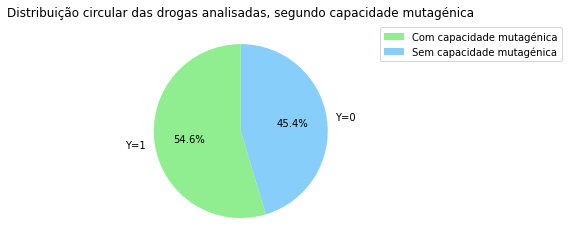

In [106]:
#gráfico circular para analisar a distribuição entre y 0 ou 1
frequence = df_global['Y'].value_counts()
print(frequence)
labels = ['Y=1', 'Y=0']
colors = ['lightgreen', 'lightskyblue']
plt.pie(frequence, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribuição circular das drogas analisadas, segundo capacidade mutagénica')
plt.legend(["Com capacidade mutagénica","Sem capacidade mutagénica"],bbox_to_anchor=(2, 1), loc='upper right', ncol=1)
plt.show()


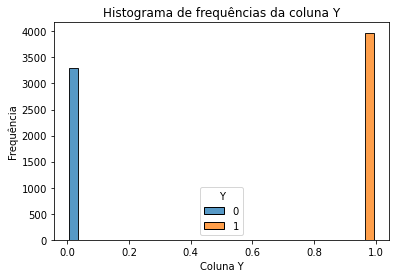

In [107]:
sns.histplot(data=df_global, x='Y', hue='Y', multiple='dodge', shrink=.8)
plt.xlabel('Coluna Y')
plt.ylabel('Frequência')
plt.title('Histograma de frequências da coluna Y')
plt.show()

Como era expectável, ambos os gráficos permitem retirar a mesma conclusão, o df_global tem mais drogas associadas a uma capacidade mutagénica presente. Todavia, a diferença não é assim tão elevada o que é adequeado para estudos que serão realizados posteriormente.

Dando uma vista de olhos mais geral pelo df_global foi possível verificar que existem diversos "grupos" de colunas com o nome bastante semelhante. Face a isso, o que fizemos foi pesquisar na literatura uma possível relevância entre o que é avaliado em cada uma dessas colunas e a capcidade mutagénica de um composto.

O que pretendiamos nesta etapa era, de certa forma, filtrar um pouco os dados, uma vez que, ainda tinhamos 211 colunas. Então a estratégia foi em primeiro lugar normalizar os dados associdados a colunas comuns, ou seja os dados associados a cada "grupo" de colunas escolhido e a partir daí escolher as colunas que tinham as médias mais elevadas e mais baixas, tendo sempre em paralelo a coluna Y (Y=1 e Y=0).

Realçar que nesta primeira fase optamos por não normalizar todo o nosso data set, uma vez que a maior parte da análise nesta fase é univariada. Assim, apenas recorremos à normalização quando estamos a comparar mais do que uma coluna ao mesmo tempo, ou seja, quando estamos a trabalhar com algum "grupo" de colunas. 

O primeiro "grupo" a ser analisado foi o "fr_" que representa a fração molar de compostos em cada molécula. Segundo a literatura algumas moléculas químicas podem estar associadas à capacidade mutagênica de uma molécula. Por exemplo, certos grupos funcionais (como os grupos nitro) ou estruturas aromáticas (como anéis benzênicos) podem aumentar a capacidade mutagênica de uma molécula. Portanto, a presença de certas subestruturas químicas na coluna "fr_" pode ser um indicador de que uma molécula tem maior ou menor potencial para ser mutagénica [1].



In [108]:
# Selecionar  as colunas que começam com "fr_" com auxilio da regex
cols_fr = df_global.filter(regex='^fr_').columns

# Aplicando a normalização apenas nessas colunas, achamos necesário
scaler = StandardScaler()
df_global[cols_fr] = scaler.fit_transform(df_global[cols_fr])
df_global[cols_fr] 


,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
10,-0.231277,-0.353990,-0.338216,6.813532,-0.147601,3.208969,-0.191858,-0.305681,-0.276524,-0.277019,...,-0.151043,-0.100753,-0.054017,-0.055082,-0.020314,-0.106561,-0.019152,-0.088286,-0.175872,-0.128981
999,-0.231277,-0.353990,-0.338216,-0.307777,-0.147601,-0.425986,-0.191858,-0.305681,-0.276524,-0.277019,...,-0.151043,-0.100753,-0.054017,-0.055082,-0.020314,-0.106561,-0.019152,-0.088286,-0.175872,-0.128981
1003,-0.231277,-0.353990,-0.338216,-0.307777,-0.147601,-0.425986,-0.191858,-0.305681,-0.276524,-0.277019,...,-0.151043,-0.100753,-0.054017,-0.055082,-0.020314,-0.106561,-0.019152,-0.088286,-0.175872,-0.128981
1005,-0.231277,-0.353990,-0.338216,-0.307777,-0.147601,-0.425986,-0.191858,-0.305681,-0.276524,-0.277019,...,-0.151043,-0.100753,-0.054017,-0.055082,-0.020314,-0.106561,-0.019152,-0.088286,-0.175872,-0.128981
1006,-0.231277,-0.353990,-0.338216,-0.307777,-0.147601,-0.425986,-0.191858,-0.305681,-0.276524,-0.277019,...,-0.151043,-0.100753,-0.054017,-0.055082,-0.020314,-0.106561,-0.019152,-0.088286,-0.175872,-0.128981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,-0.231277,-0.353990,-0.338216,-0.307777,-0.147601,-0.425986,-0.191858,-0.305681,-0.276524,-0.277019,...,-0.151043,-0.100753,-0.054017,-0.055082,-0.020314,-0.106561,-0.019152,-0.088286,-0.175872,-0.128981
993,-0.231277,-0.353990,-0.338216,-0.307777,-0.147601,-0.425986,-0.191858,-0.305681,-0.276524,-0.277019,...,-0.151043,-0.100753,-0.054017,-0.055082,-0.020314,-0.106561,-0.019152,-0.088286,-0.175872,-0.128981
994,-0.231277,3.359327,2.296862,-0.307777,-0.147601,-0.425986,-0.191858,3.291759,-0.276524,-0.277019,...,-0.151043,-0.100753,-0.054017,-0.055082,-0.020314,-0.106561,-0.019152,-0.088286,-0.175872,-0.128981
997,2.906933,-0.353990,-0.338216,-0.307777,-0.147601,-0.425986,-0.191858,-0.305681,2.560091,2.552696,...,-0.151043,-0.100753,-0.054017,-0.055082,-0.020314,-0.106561,-0.019152,-0.088286,-0.175872,-0.128981


In [109]:
# Filtrar linhas com Y=0 e selecionar colunas que começam com "fr"
df_filtered = df_global.loc[df_global['Y'] == 0].filter(regex='^fr_')

# Calcular a média das colunas e obter o nome da coluna com maior e menor média
col_max = df_filtered.mean().idxmax()
col_min = df_filtered.mean().idxmin()

print(f"Coluna com maior média: {col_max}")
print(f"Coluna com menor média: {col_min}")

Coluna com maior média: fr_COO2
Coluna com menor média: fr_benzene


In [110]:
# Filtrar linhas com Y=1 e selecionar colunas que começam com "fr"
df_filtered = df_global.loc[df_global['Y'] == 1].filter(regex='^fr_')

# Calcular a média das colunas e obter o nome da coluna com maior e menor média
col_max = df_filtered.mean().idxmax()
col_min = df_filtered.mean().idxmin()

print(f"Coluna com maior média: {col_max}")
print(f"Coluna com menor média: {col_min}")


Coluna com maior média: fr_benzene
Coluna com menor média: fr_COO2


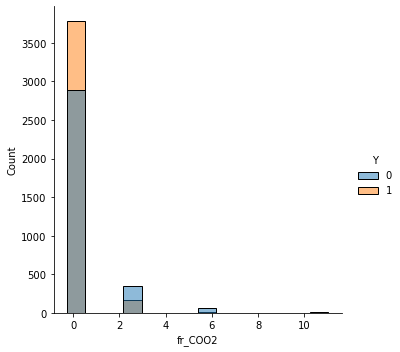

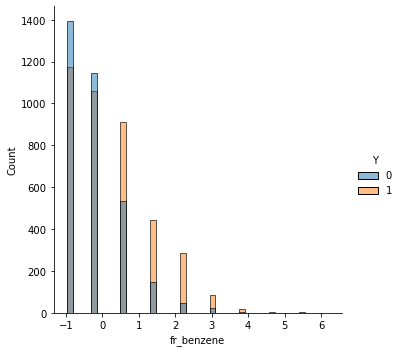

In [111]:
# Filtrar os dados por y=1 e y=0
df_y1 = df_global[df_global['Y']==1]
df_y0 = df_global[df_global['Y']==0]

# Criar o displot para fr_C002 em relação a Y
sns.displot(data=df_global, x='fr_COO2', hue='Y', kde=False)

# Criar o displot para fr_benzene em relação a Y
sns.displot(data=df_global, x='fr_benzene', hue='Y', kde=False)



O resultado obtido vai de encontro ao que era esperado no sentido em que : a maior média associada a uma capacidade mutagénica presente (Y=1) teria de ser a menor média quando se estivesse a observar a coluna Y=0 e vice-versa. Sendo assim, as duas colunas que achamos mais relevantes estudar no grupo "fr_" são fr_benzene (associada a Y=1) e fr_COO2 (associada a Y=0).

Além disso, os resultados obtidos vão de acordo ao descrito na literatura, onde o benzeno é conhecido por ser um composto químico altamente cancerígeno e mutagénico. A exposição prolongada ao benzeno pode causar danos no DNA e aumentar o risco de desenvolver cancro [2]. Portanto, o fr_benzene pode estar relacionado à capacidade mutagénica dos compostos no dataset ames. É importante ressaltar, no entanto, que a análise da relação entre fr_benzene e capacidade mutagênica poderia ser mais extensamente explorada considerando outros fatores, como a dosagem e a frequência de exposição ao benzeno. Relativamente ao COO2, um ester carboxílico, na literatura não foram encontrdas evidências científicas que indiquem que compostos com COO2, por si só, esteja, diretamente relacionado com a capacidade mutagénica tal como verificado pelos resultados.

Relativamente aos gráficos criados, a barra cinza indica a densidade de frequência que é compartilhada pelas duas categorias de Y (Y=0 e Y=1) para o "fr_" em questão. A parte colorida do gráfico indica a distribuição de fr_COO2 ou fr_benzene para cada categoria de Y. Lembrando que os valores foram previamente normalizados, a forma mais direta de interpretar estes gráfico é, por exemplo, no gráfico fr_COO2 podemos ver que todos os valores associados a Y=1 estão com fr_COO2 de 0, ou seja este tipo de molécula não está ligado à capacidade mutagénica. No gráfico do fr_benzene vemos que a maior parte dos valores >0 estão associados a Y=1.

É sabido que podem haver mais composto com elevadas médias tal como o benzeno (relativamente à coluna Y=1) e que também poderiam ter sidos considerados, contudo para permitir filtrar um pouco a nossa análise apenas temos em consideração o fr_benzene e fr_COO2.

O segundo "grupo" a ser analisado foi o "SMR_VSA", que se refere às contribuições do descritor VSA (Volume-based Surface Area) para a pontuação SMR (Small Molecule Risk) de uma molécula. O descritor VSA é uma medida que descreve a distribuição da área superficial de uma molécula, e é comumente usado em estudos de QSAR (Quantitative Structure-Activity Relationship) para prever a atividade biológica de compostos químicos [3]. EM suma, SMR_VSA é um descritor molecular que mede a distribuição da área superficial da molécula em diferentes regiões.

In [112]:
# Selecionando as colunas que começam com "SMR_VSA"
cols_SMR = df_global.filter(regex='^SMR_VSA').columns

# Aplicando a normalização apenas nessas colunas
scaler = StandardScaler()
df_global[cols_SMR] = scaler.fit_transform(df_global[cols_SMR])
df_global[cols_SMR]

,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9
10,-1.036122,-0.092389,-0.151487,2.507759,-0.439277,-0.742669,0.892621,-1.394378,0.0,-0.525029
999,-1.036122,-1.188383,-0.151487,-0.594015,-0.439277,0.429995,-0.746279,-1.394378,0.0,-0.525029
1003,-1.036122,-0.210007,-0.151487,-0.594015,-0.439277,-0.742669,-0.746279,0.896484,0.0,1.127048
1005,-1.036122,-1.188383,-0.151487,0.508951,-0.439277,0.109129,-0.074782,-0.002282,0.0,-0.525029
1006,-0.556493,-0.839079,-0.151487,-0.594015,-0.439277,-0.438454,-0.746279,0.154707,0.0,-0.525029
...,...,...,...,...,...,...,...,...,...,...
991,-1.036122,-0.839079,4.874680,-0.594015,-0.439277,-0.438454,-0.746279,-0.044570,0.0,-0.525029
993,-0.556493,-0.126579,-0.151487,-0.594015,-0.439277,-0.484314,-0.746279,0.154707,0.0,-0.525029
994,3.313985,-0.122808,-0.151487,-0.594015,-0.439277,0.335860,0.560637,0.605998,0.0,2.035962
997,-0.071560,0.565709,-0.151487,-0.594015,-0.439277,-0.742669,-0.324425,-1.394378,0.0,-0.525029


In [113]:
# Filtrar linhas com Y=0 e selecionar colunas que começam com "SMR_VSA"
df_filtered = df_global.loc[df_global['Y'] == 0].filter(regex='^SMR_VSA')

# Calcular a média das colunas e obter o nome da coluna com maior e menor média
col_max = df_filtered.mean().idxmax()
col_min = df_filtered.mean().idxmin()

print(f"Coluna com maior média: {col_max}")
print(f"Coluna com menor média: {col_min}")

Coluna com maior média: SMR_VSA5
Coluna com menor média: SMR_VSA7


In [114]:
# Filtrar linhas com Y=1 e selecionar colunas que começam com "SMR_VSA"
df_filtered = df_global.loc[df_global['Y'] == 1].filter(regex='^SMR_VSA')

# Calcular a média das colunas e obter o nome da coluna com maior e menor média
col_max = df_filtered.mean().idxmax()
col_min = df_filtered.mean().idxmin()

print(f"Coluna com maior média: {col_max}")
print(f"Coluna com menor média: {col_min}")

Coluna com maior média: SMR_VSA7
Coluna com menor média: SMR_VSA5


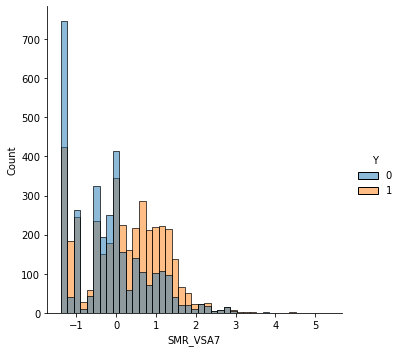

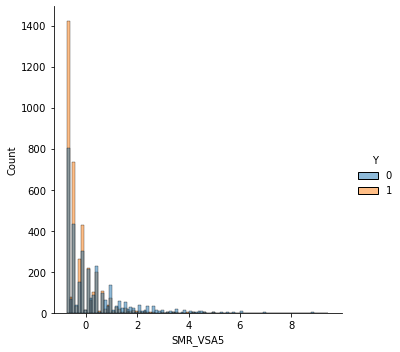

In [115]:
# Filtrar os dados por y=1 e y=0
df_y1 = df_global[df_global['Y']==1]
df_y0 = df_global[df_global['Y']==0]

# Criar o displot para fr_C002 em relação a Y
sns.displot(data=df_global, x='SMR_VSA7', hue='Y', kde=False)

# Criar o displot para fr_benzene em relação a Y
sns.displot(data=df_global, x='SMR_VSA5', hue='Y', kde=False)

As colunas SMR_VSA7 e SMR_VSA5 foram aquelas que obtiveram uma maior média quando associadas à coluna Y=1 e Y=0, respetivamente. Como já referido, SMR_VSA é um descritor molecular que mede a distribuição da área superficial da molécula em diferentes regiões. SMR_VSA5 e SMR_VSA7 são valores de SMR_VSA correspondentes às regiões 5 e 7 da molécula, respectivamente. A maior média de SMR_VSA7 em moléculas mutagênicas em comparação com SMR_VSA5 em moléculas não mutagênicas pode ser explicada por diferenças nas características estruturais das moléculas.

Moléculas mutagénicas geralmente têm uma estrutura mais complexa e incluem grupos funcionais que podem ser mais reativos e interagir com o ADN, resultando em danos no material genético. Esses grupos funcionais podem estar localizados em regiões específicas da molécula, como a região 7 (segundo os resultados). Assim, segundo os resultados podemos concluir que a região 7 das moléculas analisadas seria aquela que apresentaria uma estrutura mais complexa sendo por isso mais associdada a um potencial mutagénico.

Uma molécula com uma área superficial maior em uma determinada região pode ser mais propensa a interagir com o DNA e, portanto, pode ter uma maior capacidade mutagênica. No entanto, outros fatores, como a carga elétrica da molécula, sua polaridade e sua solubilidade em água, também podem influenciar sua interação com o ADN e, portanto, sua capacidade mutagênica. Portanto, embora uma pontuação SMR_VSA mais alta numa determinada região ou regiões possa estar associada a uma maior capacidade mutagênica, essa relação é complexa e depende de vários outros fatores.

Através dos gráficos apresentados é possivel verificar, por exemplo, no gráfico do SMR_VSA5, que realmente a coluna Y=1 está associada a menores valores deste parâmetro levando a crer que esta região não está associada a capacidade mutagénica. Todavia, pela interpretação do gráfico relativo a SMR_VSA7 o output parace não clarificar tanto uma diferença entre a coluna Y=0 e Y=1.


Em conclusão, achamos que estes parÂmetros do SMR_VSA por si só não são suficientes para criar uma associação direta entre os seus valores e capacidade mutagénica, mas juntamente com os restantes parametros podem ser úteis.

O terceiro "grupo" a ser analisado foi o "SlogP_VSA", bastante utilizada para prever certas propriedades farmacocinéticas de uma molécula, refere-se ao logaritmo do coeficiente de partição octanol-água ajustado para a forma molecular. O coeficiente de partição octanol-água é uma medida da solubilidade de uma molécula em água em comparação com a solubilidade em octanol (um solvente orgânico). A solubilidade é uma propriedade importante de uma molécula, pois pode influenciar a sua absorção, distribuição, metabolismo e excreção no organismo, bem como sua interação com biomoléculas, como proteínas e DNA [4].



In [116]:
# Selecionando as colunas que começam com "SlogP"
cols_SlogP = df_global.filter(regex='^SlogP').columns

# Aplicando a normalização apenas nessas colunas
scaler = StandardScaler()
df_global[cols_SlogP] = scaler.fit_transform(df_global[cols_SlogP])
df_global[cols_SlogP]

,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9
10,2.675908,2.513085,-0.421256,-0.441593,-0.271546,-0.795797,-0.628698,-0.780329,-1.273520,-0.240166,-0.639963,0.0
999,-0.724149,-0.607150,-0.421256,-0.441593,-1.084027,-0.795797,-0.628698,0.463243,-1.273520,-0.240166,-0.639963,0.0
1003,-0.724149,-0.607150,-0.421256,0.775564,-1.084027,-0.795797,-0.628698,-0.780329,1.308981,-0.240166,0.303593,0.0
1005,0.326800,-0.607150,-0.421256,-0.441593,-0.372749,0.084091,-0.628698,-0.198492,0.052567,-0.240166,-0.639963,0.0
1006,-0.724149,0.387300,-0.421256,-0.441593,-0.816497,-0.795797,1.494343,-0.521102,-0.212651,-0.240166,-0.639963,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
991,-0.724149,0.387300,-0.421256,-0.441593,-1.084027,-0.795797,0.906021,-0.521102,-0.212651,-0.240166,-0.218003,0.0
993,-0.724149,0.387300,-0.421256,0.444798,-0.816497,0.009979,0.631605,-0.521102,-0.212651,-0.240166,-0.639963,0.0
994,0.212169,-0.607150,3.028650,-0.441593,2.295898,0.741119,-0.628698,1.805425,-0.477868,-0.240166,-0.639963,0.0
997,-0.724149,-0.607150,-0.421256,1.284504,-0.241580,-0.138770,-0.628698,-0.780329,-1.273520,-0.240166,-0.639963,0.0


In [117]:
# Filtrar linhas com Y=0 e selecionar colunas que começam com "SlogP"
df_filtered = df_global.loc[df_global['Y'] == 0].filter(regex='^SlogP')

# Calcular a média das colunas e obter o nome da coluna com maior e menor média
col_max = df_filtered.mean().idxmax()
col_min = df_filtered.mean().idxmin()

print(f"Coluna com maior média: {col_max}")
print(f"Coluna com menor média: {col_min}")

Coluna com maior média: SlogP_VSA5
Coluna com menor média: SlogP_VSA8


In [118]:
# Filtrar linhas com Y=1 e selecionar colunas que começam com "SlogP"
df_filtered = df_global.loc[df_global['Y'] == 1].filter(regex='^SlogP')

# Calcular a média das colunas e obter o nome da coluna com maior e menor média
col_max = df_filtered.mean().idxmax()
col_min = df_filtered.mean().idxmin()

print(f"Coluna com maior média: {col_max}")
print(f"Coluna com menor média: {col_min}")

Coluna com maior média: SlogP_VSA8
Coluna com menor média: SlogP_VSA5


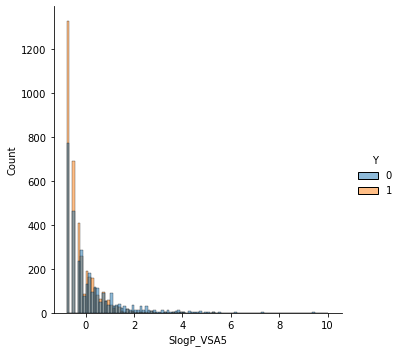

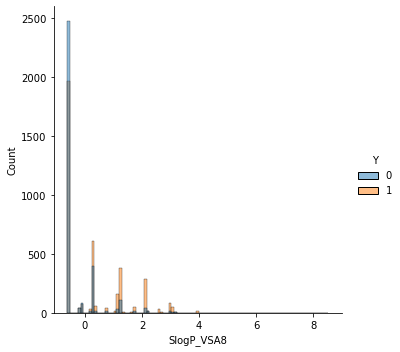

In [119]:
# Filtrar os dados por y=1 e y=0
df_y1 = df_global[df_global['Y']==1]
df_y0 = df_global[df_global['Y']==0]

# Criar o displot para fr_C002 em relação a Y
sns.displot(data=df_global, x='SlogP_VSA5', hue='Y', kde=False)

# Criar o displot para fr_benzene em relação a Y
sns.displot(data=df_global, x='SlogP_VSA8', hue='Y', kde=False)

O SlogP_VSA pode estar associado à capacidade mutagênica de uma molécula, pois pode influenciar sua absorção, distribuição, metabolismo e excreção no organismo, bem como sua interação com biomoléculas, como proteínas e ASN. Moléculas com alta exposição superficial e com valores elevados de SlogP_VSA podem ter uma maior tendência a se acumular em tecidos adiposos e a atravessar membranas biológicas, o que pode afetar a interação da molécula com o ADN e levar a danos genéticos e mutações. Por outro lado, moléculas com baixo SlogP tendem a ser mais hidrofílicas e podem ser eliminadas mais facilmente pelo organismo, diminuindo a exposição a possíveis efeitos mutagénicos [4].

Assim, segundo os resultados obtidos podemos concluir que a coluna SlogP_VSA8 ao ter maior valores pode estar associado a uma capacidade mutagénica presente, ao passo que a coluna SlogP_VSA5 como tem menor média não é expectável que tenha associação a uma capacidade mutagénica. Esta diferença de valores pode estar associada com a região da droga analisada e com o tipo de átomos existentes sendo a região 5 uma zona com átomos de nitrogénios e oxigénios alifáticos e a região 8 com anéis aromáticos e heterocíclicos.

Relativamente aos gráficos a interpretação vai de acordo ao referido na análise do primeiro e segundo grupos analisados, isto é, a maior parte das drogas associadas a Y=0, sem capcidade mutagénica, têm valores ausentes na coluna SlogP_VSA8 e as drogas com capacidade mutagénica têm valores mais elevados. No que concerne ao gráfico que representa a associação da capacidade mutagénica, Y=0 ou Y=1, e SlogP_VSA5 a interpretação é semelhante, mas feita de maneira inversa, ou seja, a maior parte dos valores de SlogP_VSA5, associados a Y=1, são baixos e os valores mais elevados estão associados a um Y=0. 

Salientar que, assim como acontece com outros descritores moleculares, a relação entre SlogP_VSA e a capacidade mutagénica de uma molécula é complexa e depende de muitos outros fatores, como a presença de grupos funcionais reativos e a estrutura tridimensional da molécula. Portanto, a análise de dados de SlogP_VSA por si só não é suficiente para determinar se uma molécula é mutagênica ou não.

De seguida, decidimos explorar o MinAbsEStateIndex e MaxAbsEStateIndex que são descritores moleculares que medem a polaridade e a eletronegatividade de uma molécula.

O MinAbsEStateIndex é o valor absoluto do menor valor de índice de estado de elétrons (EState) na molécula, enquanto o MaxAbsEStateIndex é o valor absoluto do maior valor de índice de estado de elétrons na molécula. O EState é uma medida de eletronegatividade que atribui valores numéricos aos átomos em uma molécula com base em sua capacidade de atrair eletrões em uma ligação covalente.

Em termos gerais, quanto maior o valor de MinAbsEStateIndex ou MaxAbsEStateIndex, maior a polaridade e a eletronegatividade da molécula, o que pode estar associado a uma maior capacidade mutagênica. Moléculas polares e eletronegativas têm maior probabilidade de interagir com moléculas biológicas, como proteínas e ADN, levando a danos genéticos e mutações [6] [7]. No entanto, é importante lembrar que o efeito de um descritor molecular específico na capacidade mutagénica pode ser influenciado por outros fatores, como a estrutura química geral da molécula e a dose. Além disso, no caso da polaridade molecular por si só, não induz a mutação, mas indiretamente pode fazê-lo por, por exemplo, inibição de enzimas funcionais levando a condições favoráveis de mutagênese [7].

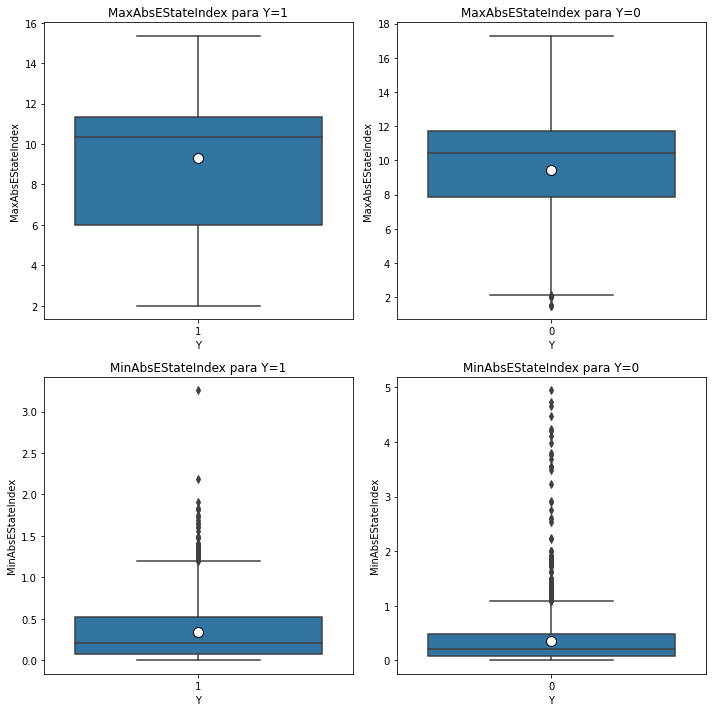

In [120]:
# criar os quatro dataframes para cada combinação de y e coluna
df_y1_maxabs = df_global[df_global['Y'] == 1][['Y', 'MaxAbsEStateIndex']]
df_y0_maxabs = df_global[df_global['Y'] == 0][['Y', 'MaxAbsEStateIndex']]
df_y1_minabs = df_global[df_global['Y'] == 1][['Y', 'MinAbsEStateIndex']]
df_y0_minabs = df_global[df_global['Y'] == 0][['Y', 'MinAbsEStateIndex']]

# criar a figura e os subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# plotar cada boxplot nos subplots correspondentes
sns.boxplot(x='Y', y='MaxAbsEStateIndex', data=df_y1_maxabs, showmeans=True, meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"10"}, ax=axs[0, 0])
axs[0, 0].set_title('MaxAbsEStateIndex para Y=1')

sns.boxplot(x='Y', y='MaxAbsEStateIndex', data=df_y0_maxabs, showmeans=True, meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"10"}, ax=axs[0, 1])
axs[0, 1].set_title('MaxAbsEStateIndex para Y=0')

sns.boxplot(x='Y', y='MinAbsEStateIndex', data=df_y1_minabs, showmeans=True, meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"10"}, ax=axs[1, 0])
axs[1, 0].set_title('MinAbsEStateIndex para Y=1')

sns.boxplot(x='Y', y='MinAbsEStateIndex', data=df_y0_minabs, showmeans=True, meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"10"}, ax=axs[1, 1])
axs[1, 1].set_title('MinAbsEStateIndex para Y=0')

# ajustar o espaçamento entre os subplots
plt.tight_layout()

# exibir o gráfico
plt.show()





In [121]:
df_global.loc[df_global['MaxAbsEStateIndex'].nlargest(5).index, ['MaxAbsEStateIndex', 'Y']]


,MaxAbsEStateIndex,Y
6175,17.286264,0
5396,16.859064,0
4765,15.351137,1
6756,15.351137,1
2471,15.192673,1


In [122]:
df_global.loc[df_global['MinAbsEStateIndex'].nlargest(5).index, ['MinAbsEStateIndex', 'Y']]


,MinAbsEStateIndex,Y
863,4.944445,0
3917,4.736111,0
6445,4.666666,0
4989,4.475013,0
5727,4.236111,0


Da análise dos boxplot criados, é possivel verificar de imediato que os resultados não vão de acordo ao que era expactável, uma vez que, os valores mais elevados das colunas analisadas encontram-se associados a um Y=0. Este aspecto pode ser devido à interação de outros fatores no decorrer do precesso de análise, tais como a dose ou a própria estrutura química. Isto não significa que os dados que temos estão errados, ou algo do género, apenas vem salientar o que temos referido que é, associar a capcidade mutagénica a uma ou duas colunas por si só pode nao ser suficiente nem a estratégia mais correta.


Além disso, as médias representadas pela bola branca também parecem bastante semelhantes e na coluna MinAbsEStateIndex parece existir um conjunto de pontos outliers que também podem interferir negativamente com a visualização dos dados e respetivas conclusões

O QED (Quantitative Estimate of Drug-likeness) é um índice que mede a probabilidade de uma molécula ser um bom fármaco com base em sua estrutura química. O QED varia de 0 a 1, onde valores mais próximos de 1 indicam maior probabilidade de a molécula ser um bom fármaco [8]. Desta forma, o nosso intuito foi explorar esta coluna e verificar se os dados obtidos vao de acordo ao expectável na medida em que se o qed tiver um valor muito elevado o farmaco é bom e portanto não terá capacidade mutagénica presente.

In [123]:
from scipy.stats import shapiro

stat, p_value = shapiro(df_global['qed'])

print(f'Statistics={stat:.4f}, p-value={p_value:.9f}')
if p_value > 0.05:
    print('A distribuição é normal')
else:
    print('A distribuição não é normal')


Statistics=0.9967, p-value=0.000000000
A distribuição não é normal


c:\Users\guilh\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


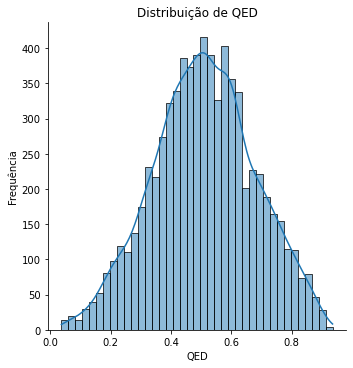

In [124]:
sns.displot(df_global, x='qed', kde=True)
plt.title('Distribuição de QED')
plt.xlabel('QED')
plt.ylabel('Frequência')
plt.show()

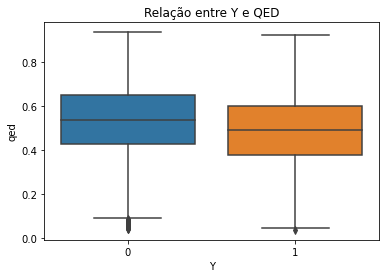

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt

# separar os dados por valor de Y
df_y1 = df_global[df_global['Y'] == 1]
df_y0 = df_global[df_global['Y'] == 0]

# criar o boxplot
sns.boxplot(x='Y', y='qed', data=df_global)
plt.title('Relação entre Y e QED')
plt.xlabel('Y')
plt.ylabel('qed')
plt.show()

Em relação à capacidade mutagénica, a literatura científica indica que compostos com maior QED tendem a ter menor capacidade mutagénica, já que eles são mais propensos a possuir perfis moleculares que são mais compatíveis com a interação com proteínas-alvo específicas e menos propensos a se ligarem aleatoriamente ao ADN, reduzindo assim o risco de danos ao material genético [9]. Como é possivel verificar pela análise do boxplot, a informação descrita na literatura não pôde deveras ser observada.

No entanto, é importante lembrar que a capacidade mutagênica também depende de outros fatores, como a presença de grupos funcionais específicos, tamanho da molécula e estrutura química geral, portanto, a relação entre QED e capacidade mutagênica não é determinística e precisa ser avaliada caso a caso.

Algo que nos dispertou interesse foi verificar como seria a distribuição dos pesos molecuares exatos das moléculas em análise. E, posteriormente, verificar se poderia existir uma associação entre por exemplo moléculas com peso molecular elevado e sua determinada capacidade mutagénica.
O ExactMolWt é o peso molecular exato de uma molécula, ou seja, é a soma das massas atómicas de todos os átomos presentes na molécula, levando em consideração os isótopos naturais e suas abundâncias relativas. É uma medida importante para caracterizar a estrutura química de uma molécula e é frequentemente utilizada para avaliar a relação entre a estrutura molecular de um composto e suas propriedades físico-químicas e biológicas, como a capacidade mutagénica [10].


In [126]:
from scipy.stats import shapiro

stat, p_value = shapiro(df_global['ExactMolWt'])

print(f'Statistics={stat:.4f}, p-value={p_value:.4f}')
if p_value > 0.05:
    print('A distribuição é normal')
else:
    print('A distribuição não é normal')




Statistics=0.9301, p-value=0.0000
A distribuição não é normal


c:\Users\guilh\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


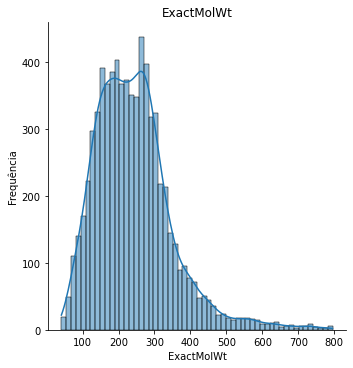

In [127]:
sns.displot(df_global, x='ExactMolWt', kde=True)
plt.title('ExactMolWt')
plt.xlabel('ExactMolWt')
plt.ylabel('Frequência')
plt.show()

Através do teste shapiro foi possivel observar que a distribuição dos dados associação ao ExactMolWt não é normal. Todavia, o nosso principal foco nesta fase de análise era associar a capacidade mutagénica de uma droga a um eventual range de peso molecular.

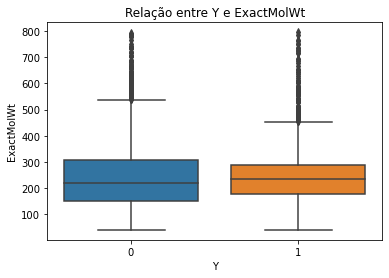

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt

# separar os dados por valor de Y
df_y1 = df_global[df_global['Y'] == 1]
df_y0 = df_global[df_global['Y'] == 0]

# criar o boxplot
sns.boxplot(x='Y', y='ExactMolWt', data=df_global)
plt.title('Relação entre Y e ExactMolWt')
plt.xlabel('Y')
plt.ylabel('ExactMolWt')
plt.show()


Pela análise do boxplot demonstrado acima, em termos visuais, não parece que possamos associar um determinado range de peso molecular à capacidade mutagénica. Todavia a literatura, diz o contrário, mas também refere que a presença de determinados grupos químicos e suas interações têm um efeito mais preponderante na capacidade mutagénica [10].

Para aprofundar a análise univariada já realizada é possivel ainda utilizar testes estatisticos que vão permitir ter uma maior certeza de quais as features com maior ou menor relevância em relação à coluna Y. Desta forma, podemos utilizar o teste t-Student para comparar as médias das variáveis independentes entre as duas classes de Y ( 0 e 1, associado à capacidade mutagénica).

Assim, o primeiro passo foi verificar qual destas colunas dispõem de distribuição normmal, realizando o teste de shapiro, sendo que a H0: segue uma distribuição normal e H1: não segue uma distribuição normal.

In [129]:
sig_level = 0.05  
normal_cols = []  #lista para guardar as colunas com distribuição normal
non_normal_cols = []  # lista para guardar as colunas com distribuição não normal

for col in df_global.iloc[:, 3:210]:
    stat, p_value = shapiro(df_global[col])
    
    if p_value > sig_level:
        normal_cols.append(col)
    else:
        non_normal_cols.append(col)

print(f'Colunas com distribuição normal: {normal_cols}')
print(f'Colunas com distribuição não normal: {non_normal_cols}')


Colunas com distribuição normal: ['SMR_VSA8', 'SlogP_VSA9', 'fr_prisulfonamd']
Colunas com distribuição não normal: ['MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR

c:\Users\guilh\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\guilh\anaconda3\lib\site-packages\scipy\stats\morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


A maioria das colunas presentes do dataframe não dispõem de distribuição normal, ou seja, na maior parte das vezes o H0 foi rejeitado (pois p-value < alfa). Sendo assim, para as colunas que têm uma distribuição normal, foi realizado teste t, para as restantes foi utilizado o teste de Mann-Whitney, onde as hipóteses para ambos os testes são:
H0: Não há diferenças significativas entre a feature em análise e a capacidade mutagénica; H1- Há diferenças significativas entre a feature em análise e a capacidade mutagénica.

In [130]:
# selecionar as colunas não-normais
non_normal_cols = [col for col in df_global.columns[3:211] if col not in normal_cols]

results = {}
for col in normal_cols:
    y0 = df_global.loc[df_global['Y'] == 0, col]
    y1 = df_global.loc[df_global['Y'] == 1, col]
    stat, p_value = ttest_ind(y0, y1)
    print(p_value)
# percorrer as colunas não-normais e calcular o teste de Mann-Whitney
for col in non_normal_cols:
    y0 = df_global.loc[df_global['Y'] == 0, col]
    y1 = df_global.loc[df_global['Y'] == 1, col]
    stat, p_value = mannwhitneyu(y0, y1, alternative='two-sided')
    results[col] = p_value

# classificar o dicionário com base nos valores de p-value
sorted_results = sorted(results.items(), key=lambda x: x[1])
print(sorted_results)

top10_cols = [col[0] for col in sorted_results[:10]]
top10_cols.insert(0, "Y")


print(top10_cols)




nan
nan
nan
[('SlogP_VSA8', 1.0525420266464707e-133), ('fr_nitro', 5.218876650092251e-91), ('HallKierAlpha', 5.698375472638977e-91), ('NumAromaticRings', 1.1374805682231892e-90), ('SMR_VSA5', 2.113822892051272e-75), ('fr_benzene', 5.176000102261982e-75), ('NumAromaticCarbocycles', 6.741056973249058e-75), ('SMR_VSA7', 8.202725422310558e-69), ('RingCount', 2.108773157845818e-65), ('SlogP_VSA10', 3.499413533458884e-65), ('fr_nitro_arom_nonortho', 1.3612125803025288e-64), ('fr_nitro_arom', 7.905058308167507e-63), ('fr_NH0', 2.951590245271424e-61), ('fr_bicyclic', 8.377633994540488e-60), ('FractionCSP3', 3.553354269431986e-58), ('BertzCT', 1.501653091633677e-56), ('SMR_VSA10', 6.392302388734683e-54), ('SlogP_VSA5', 9.659282630468409e-54), ('Kappa3', 7.869880615253084e-52), ('VSA_EState6', 2.4578108419885353e-50), ('SlogP_VSA6', 2.5685823224424386e-50), ('VSA_EState8', 4.095917485980558e-41), ('NumSaturatedCarbocycles', 3.61441518067857e-37), ('fr_nitroso', 3.1865124545630994e-36), ('PEOE_VS

In [131]:
#exemplo de uma das featues que teve pvalue=nan, tem valor de 0 quer para Y=0 como para y=1 ou seja sem variancia
print(df_global['fr_prisulfonamd'])


10      0.0
999     0.0
1003    0.0
1005    0.0
1006    0.0
       ... 
991     0.0
993     0.0
994     0.0
997     0.0
998     0.0
Name: fr_prisulfonamd, Length: 7273, dtype: float64


É possivel observar que o p-value das 3 features que apresentaram, segundo o teste de shapiro, distribuição normal é "nan". Isto é devido ao facto de estas colunas apenas apresentarem um unico valor, ou seja, a variância das amostras é zero. Assim, apenas tivemos em consideração as restantes features, escolhendo um top 10 das colunas que segundo o teste de Mann-Whitney apresentam um menor p-value e por isso uma maior diferença siginifcativa o que pode significar uma maior contribuição na capacidade mutagénica de uma droga.

Referenciar apenas que introduzimos no dicionário os dados da coluna Y, para ser possivel observar a correlação entre esta variavel e as restantes 10 que obtiveram um menor p-value. Esta análise é usada para medir o grau de associação entre duas variáveis, de modo que se uma variável se altera, a outra também se altera de alguma forma. O coeficiente de correlação é uma medida numérica que varia entre -1 e 1, em que valores próximos a -1 indicam uma correlação negativa forte, valores próximos de 1 indicam uma correlação positiva forte, e valores próximos de 0 indicam ausência de correlação. 

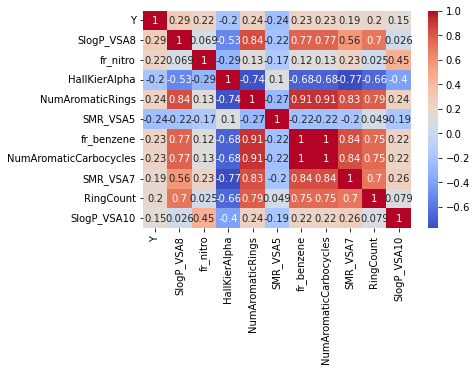

In [132]:
df_top_10 = df_global[top10_cols]

# Calcular a matriz de correlação
corr = df_top_10.corr()

# Plotar a matriz de correlação
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()


Relativamente à análise do heatmap , em primeiro lugar, é possivel observar uma elevada correlação positiva por exemplo entre a coluna NumAromaticRings e fr_benzene e NumAromaticCarbocycles o que é completamente óbvio e reforça veracidade de posteriores interpretações.


Reforçando e direcionando a análise para a correlação das features em questão com a coluna Y, observa-se de um modo geral que nenhuma delas tem uma correlação muito forte (perto de 1 ou -1), quer seja positiva ou negativa. Este aspeto reforça o que é descrito na literatura, ou seja, na análise deste tipo de dataset de exploração da capacidade mutagénica de uma droga é estritamente necessário ter em consideração mais do que uma feature.


Fazendo um paralelismo com os resultados anteriores, é possivel verificar que a correlação entre a coluna Y e a SMR_VSA5 é negativa o que faz sentido, uma vez que esta foi descrita anteriormente como sendo significativamente diferente, mas associada a uma não capacidade mutagénica (daí o sinal -). 

O contrário se verifica quando se analisa a correlação positiva entre SloP_VSA8 e fr_benzene e a coluna Y, indo de encontro ao referido anteriormente onde ambas colunas são significativamente diferentes e associadas à existência da capacidade mutagénica (sinal +).

Poderíamos realizar um heatmap, por exemplo, relacionando um top 30 colunas, com mais diferença siginificativa mas a interpretação dos dados iria se basear nos mesmos parâmetros. Contudo, queremos reforçar a ideia de que na interpetação deste dataset e na associação de certas colunas à capacidade mutagénica é necessário sempre ter em consideração a influência de diversas colunas (features).

## Análise estatísticas multivariada (não-supervisionada)

# Pré-processamento dos dados

Uma vez que agora vamos analisar todas as colunas como um todo e não individual o primeiro passo foi realizar a normalização dos dados (features).

In [133]:
array_df = preprocessing.scale(df_features)
data_scale =  pd.DataFrame(array_df, index =df_features.index , columns = df_features.columns)

c:\Users\guilh\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


In [134]:
data_scale.mean()

MaxEStateIndex      -2.350809e-17
MinEStateIndex      -7.724659e-17
MaxAbsEStateIndex   -2.350809e-17
MinAbsEStateIndex   -1.147756e-16
qed                  6.838717e-18
                         ...     
fr_thiazole          1.032959e-15
fr_thiocyan          5.857627e-16
fr_thiophene        -8.816641e-16
fr_unbrch_alkane    -4.775882e-16
fr_urea              3.006593e-16
Length: 208, dtype: float64

In [135]:
data_scale.std()

MaxEStateIndex       1.000069
MinEStateIndex       1.000069
MaxAbsEStateIndex    1.000069
MinAbsEStateIndex    1.000069
qed                  1.000069
                       ...   
fr_thiazole          1.000069
fr_thiocyan          1.000069
fr_thiophene         1.000069
fr_unbrch_alkane     1.000069
fr_urea              1.000069
Length: 208, dtype: float64

Conseguimos avaliar, tal como era esperado, a correta normalização dos dados sendo que a média e o desviopadrão estão muito próximos do valor 0 e 1 , respetivamente.

PCA é uma técnica de análise multivariada que tem como objetivo reduzir a dimensionalidade dos dados mantendo o máximo de informação possível. As componentes principais são ordenadas em ordem decrescente de importância, de modo que o primeiro componente principal representa a maior parte da variância nos dados, o segundo componente representa a segunda maior parte e assim por diante. Dessa forma, é possível reduzir a dimensionalidade dos dados mantendo a maior parte da informação importante.

Para este dataset, nós selecionamos um numero de componentes principais que representasse pelo menos 70 % dos dados. Para esse fim, a primeira etapa foi realizar de uma forma automática, a soma de todos os principais componentes, ordenados de forma descendente, até obter 0.7 e a partir daí saber o numero total de componentes necessários(n_components).  

In [136]:
#automatização da procura de um n
n_components = 1
pca = PCA(n_components=n_components)
pca.fit(data_scale)
var_exp = pca.explained_variance_ratio_.cumsum()[n_components-1]

while var_exp < 0.7:
    n_components += 1
    pca = PCA(n_components=n_components)
    pca.fit(data_scale)
    var_exp = pca.explained_variance_ratio_.cumsum()[n_components-1]

print(f"Número mínimo de componentes principal para representar 70% da variância: {n_components}")


Número mínimo de componentes principal para representar 70% da variância: 31


Var. explicada: [0.17022739 0.07935862 0.05283115 0.0383773  0.03248811 0.03058048
 0.02723756 0.02328308 0.02083351 0.01846129 0.0173818  0.01693091
 0.01486117 0.01305618 0.01173676 0.01172388 0.01116447 0.01024934
 0.00985996 0.00951329 0.00925184 0.00875565 0.00849947 0.00810613
 0.00782021 0.00754481 0.00744272 0.00717452 0.00672428 0.00654854
 0.00635775]
Soma: 70.43821708985834 %


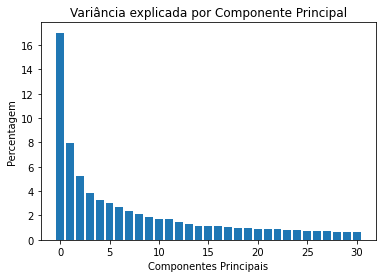

In [137]:
#Estamos a trabalhar com 31 componentes principais pois temos como obetivo obter 70% do dados
n=n_components
pca_ames = PCA(n_components=n)
pca_ames.fit(data_scale)
X_r = pca_ames.transform(data_scale) 

print('Var. explicada: %s'% str(pca_ames.explained_variance_ratio_))
print('Soma:', sum(pca_ames.explained_variance_ratio_) * 100, "%")

plt.bar(range(n), pca_ames.explained_variance_ratio_*100)
#plt.xticks(range(n), ['PC'+str(i) for i in range(1, n+1)])
plt.title("Variância explicada por Componente Principal")
plt.ylabel("Percentagem")
plt.xlabel("Componentes Principais")
plt.show()

O gráfico acima demonstra a representação de cada componente principal, sendo de realçar a grande diferença entre o primeiro componente principal (17% do dataset) e o trigésimo (0.06%).

<function matplotlib.pyplot.show(close=None, block=None)>

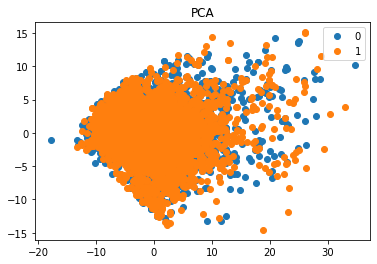

In [138]:
for c in df_global["Y"].unique():
    y= df_global.index[df_global['Y']== c]-1
    plt.plot(X_r[y,0], X_r[y,1], 'o', label= c)
plt.title("PCA")
plt.legend(loc='best', shadow=False)
plt.show

Este código realiza um gráfico de dispersão dos dois primeiros componentes principais do PCA em relação às duas classes presentes na variável Y do seu conjunto de dados. 


Este gráfico mostra a representação dos dados em duas dimensões, com o eixo X representando a primeira componente principal e o eixo Y representando a segunda componente principal. Cada ponto no gráfico representa uma observação do conjunto de dados, e a cor do ponto indica a classe a que pertence (Y=0 ou Y=1).

A partir desse gráfico, é possível observar como as classes se separam no espaço das duas primeiras componentes principais. Neste caso em concreto as classes estão na sua maior parte sobrepostas, o que poderia significar que as variáveis originais não sejam tão boas para discriminar as classes e outras técnicas de análise e modelagem podem ser necessárias. Lembrando ainda, que existem 30 componentes principais que representam 70 % dos dados e aqui apenas estamos a trabalhar com duas componentes principais que representam aproximadamente 25 % dos dados, ou seja estas duas componentes principais não são suficientes para capturar todas as variações presentes nos dados. Além disso, o gráfico em questão é de duas dimensões sendo que muito provavelmte para esta situação o mais adequado seria, se possivel, explorar gráficos com mais dimensões (o que dificultaria sua interpretação) ou até usar outras ferramentas de análise.

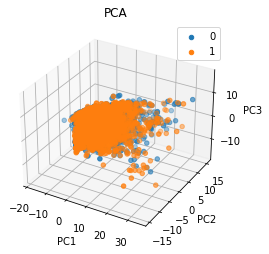

In [139]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for c in df_global["Y"].unique():
    y = df_global.index[df_global['Y'] == c] - 1
    ax.scatter(X_r[y, 0], X_r[y, 1], X_r[y, 2], label=c)

ax.set_title("PCA")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend(loc='best', shadow=False)

plt.show()


À medida que aumentamos as dimensões dos gráfico as classes podem ter tendância a ficar menos sobrepostas, contudo fica mais dificil ao olho humano a sua interpretação.

### tSNE

t-SNE (t-Distributed Stochastic Neighbor Embedding) é um algoritmo de redução de dimensionalidade,  particularmente útil para visualizar dados em duas ou três dimensões, tornando mais fácil a identificação de clusters ou padrões nos dados. Ao contrário do PCA, que é linear e preserva a estrutura global dos dados, o t-SNE é não-linear e enfatiza as diferenças locais nos dados, o que pode torná-lo mais adequado para a visualização de clusters em dados complexos e não-lineares.

O parâmetro n_components do t-SNE determina a dimensão da representação de saída dos dados, tal como descrito anteriormente com o PCA. Como temos grande número de colunas e desejamos reduzir o número de dimensões para facilitar a visualização optamos por usar um número pequeno de componentes, como 2 ou 3.

O parâmetro n_iter no t-SNE é o número de iterações do algoritmo, ou seja, é o número de vezes que o t-SNE irá ajustar os pontos em cada iteração. Ele é usado para otimizar a posição dos pontos de modo que eles fiquem mais separados em relação às suas classes, mas tem um custo computacional alto. Em geral, aumentar o valor de n_iter pode ajudar a melhorar a qualidade da solução encontrada, especialmente se a estrutura dos dados é complexa. No entanto, também pode levar a problemas de sobreajuste, onde o algoritmo se concentra muito nos detalhes locais dos dados e perde a estrutura global dos dados. Portanto, é importante encontrar um equilíbrio entre o tempo de execução e a qualidade da solução ao ajustar o valor de n_iter. Sendo assim utilizamos o valor padrão de 1000, que pode ser sempre ajustado. 



c:\Users\guilh\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\guilh\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

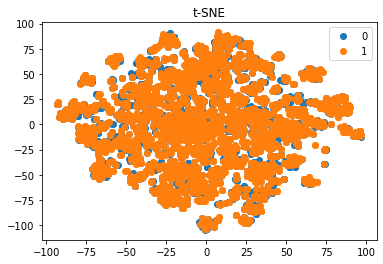

In [140]:
tsne= TSNE(n_components= 2, n_iter=1000)
points= tsne.fit_transform(data_scale)
for c in df_global["Y"].unique():
    y= df_global.index[df_global['Y']== c]-1
    plt.plot(points[y,0], points[y,1], 'o', label= c)
plt.title("t-SNE")
plt.legend(loc='best', shadow=False)
plt.show

c:\Users\guilh\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\guilh\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


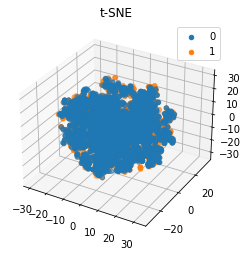

In [141]:
n_components = 3

tsne = TSNE(n_components=n_components, n_iter=1000)

points = tsne.fit_transform(data_scale)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for c in df_global["Y"].unique():
    y = df_global.index[df_global['Y'] == c] - 1
    ax.scatter(points[y, 0], points[y, 1], points[y, 2], label=c)

ax.set_title("t-SNE")
ax.legend(loc='best', shadow=False)
plt.show()


Existem diferenças entre os graficos de dispersão apresentados para PCA e para t-SNE.


O t-SNE ao ser técnica não linear, tenta preservar a estrutura local dos dados, ou seja, as relações entre os pontos próximos entre si. Isso pode levar a uma maior sobreposição de pontos no gráfico de dispersão, especialmente quando há muitos pontos ou muitas dimensões nos dados originais.

O PCA, por outro lado, é uma técnica linear que tenta encontrar uma nova base de dados que maximize a variância dos dados em cada componente principal. Como resultado, as informações globais dos dados são mais preservadas e a sobreposição de pontos no gráfico de dispersão é menor. No entanto, pode ser que algumas informações importantes sejam perdidas quando se usa o PCA para reduzir a dimensionalidade dos dados, especialmente se a relação entre as variáveis não for linear.

Em suma, a diferença em termos de visualização dos gráficos não é muito acentudada, mas pode ser justificada pelos diferentes princípios explorados pelo t-SNE e pelo PCA.

## Clustering

### Dendograma

Clustering hierárquico é uma técnica de agrupamento de dados que procura criar uma estrutura hierárquica de clusters (ou grupos), onde cada nó do cluster pode ser um cluster ou um objeto individual. 

Uma das principais vantagens do clustering hierárquico é que ele permite visualizar a estrutura do cluster em um dendograma, que é uma representação gráfica da estrutura hierárquica do cluster. Isso pode ser útil para entender melhor como os dados estão agrupados e como as diferentes variáveis afetam a estrutura do cluster.


Na primeira estratégia de clustering realizada, cada objeto é inicialmente considerado como um cluster e, em seguida, os clusters são combinados em pares, com base em uma medida de  distância entre eles. Essa medida pode ser a distância Manhattan, Euclidiana,  correlação entre outras. Sendo de realçar, que quando o numero de colunas a ser analisado é muito extenso talvez seja mais apropriado utilizar a distancia de correlação.

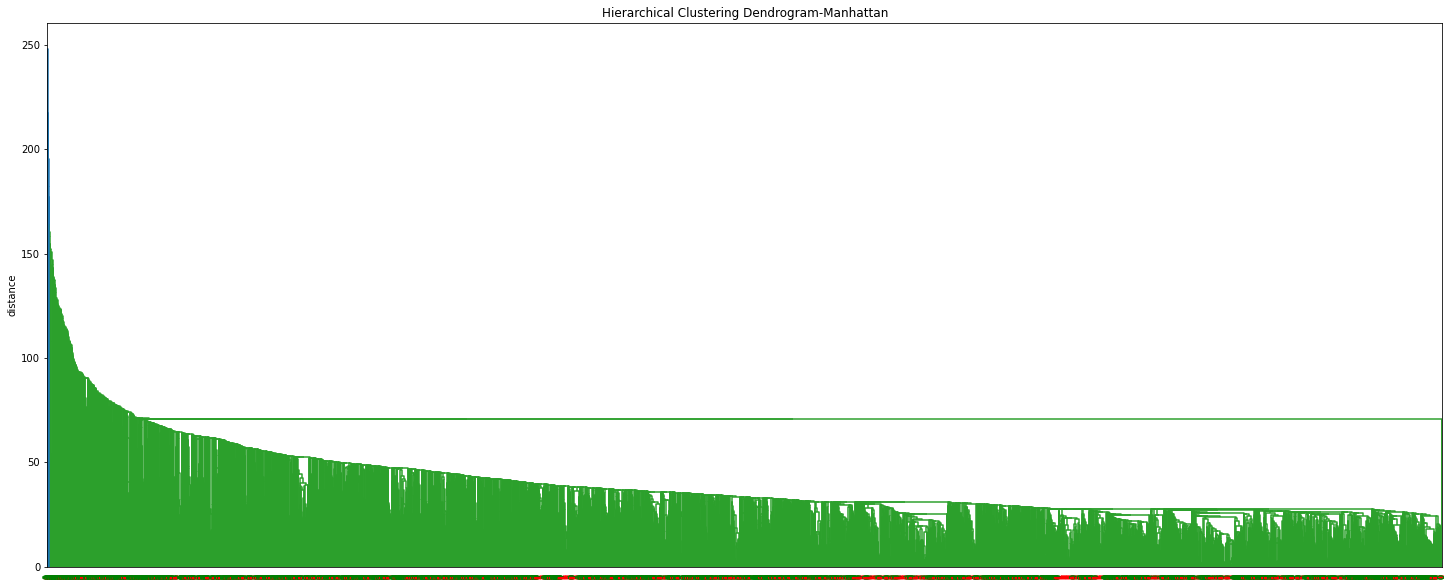

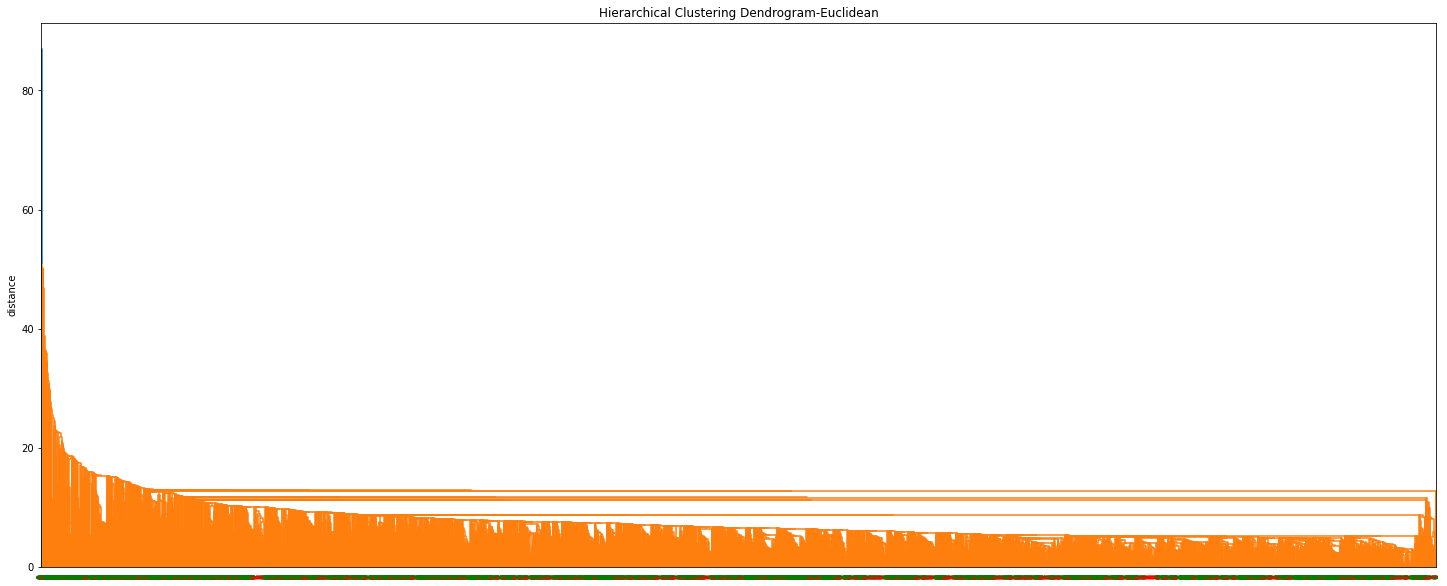

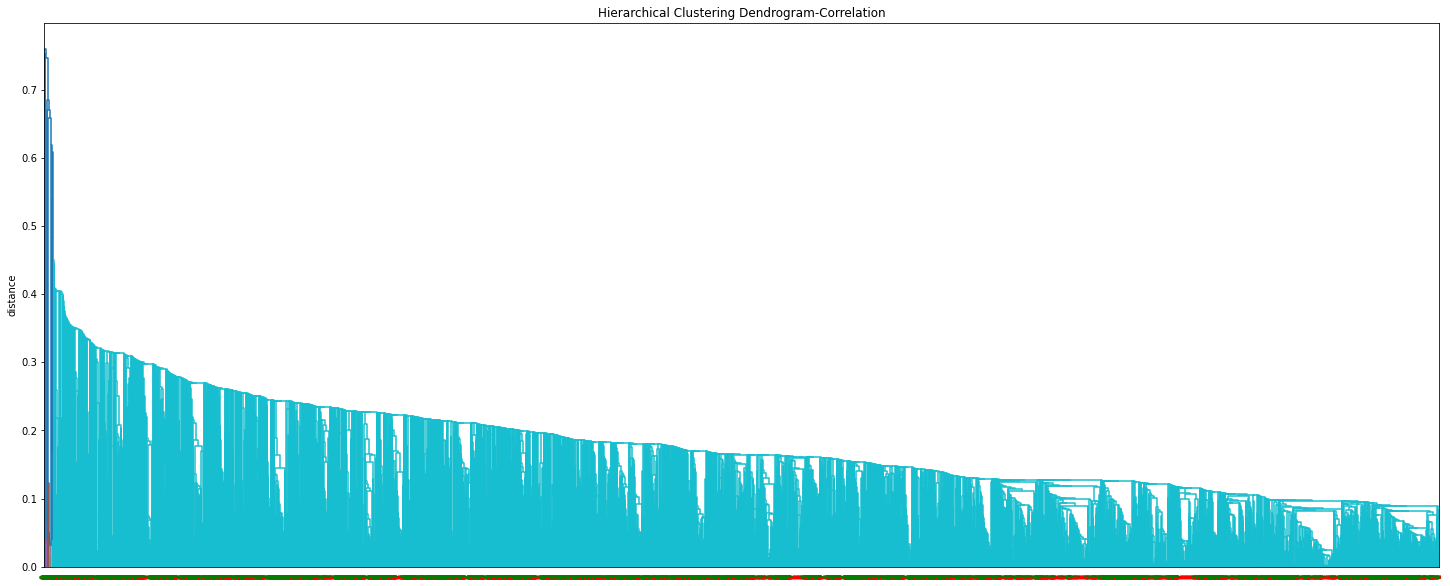

In [142]:
#Distância Manhattan
Z = linkage(data_scale, method='single', metric='cityblock')

# calculate full dendrogram
plt.figure(figsize=(25, 10))
dendrogram(
    Z,
    labels=list(df_ames.iloc[:,2]),
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)

plt.title('Hierarchical Clustering Dendrogram-Manhattan')
plt.ylabel('distance')
# Plota o dendrograma colorindo as folhas de acordo com a classe
label_colors = {"1": 'r', "0": 'g'}
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

plt.show()

#Distância Euclidean
Z = linkage(data_scale, method='single', metric='euclidean')

#calculate full dendrogram
plt.figure(figsize=(25, 10))
dendrogram(
    Z,
    labels=list(df_ames.iloc[:,2]),
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)

plt.title('Hierarchical Clustering Dendrogram-Euclidean')
plt.ylabel('distance')
# Plota o dendrograma colorindo as folhas de acordo com a classe
label_colors = {"1": 'r', "0": 'g'}
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

plt.show()

#correlation
Z = linkage(data_scale, method='single', metric='correlation')

#calculate full dendrogram
df_global['Y'] = df_global['Y'].astype(str)
plt.figure(figsize=(25, 10))
dendrogram(
    Z,
    labels=list(df_ames.iloc[:,2]),
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)

plt.title('Hierarchical Clustering Dendrogram-Correlation')
plt.ylabel('distance')
# Plota o dendrograma colorindo as folhas de acordo com a classe
label_colors = {"1": 'r', "0": 'g'}
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

plt.show()

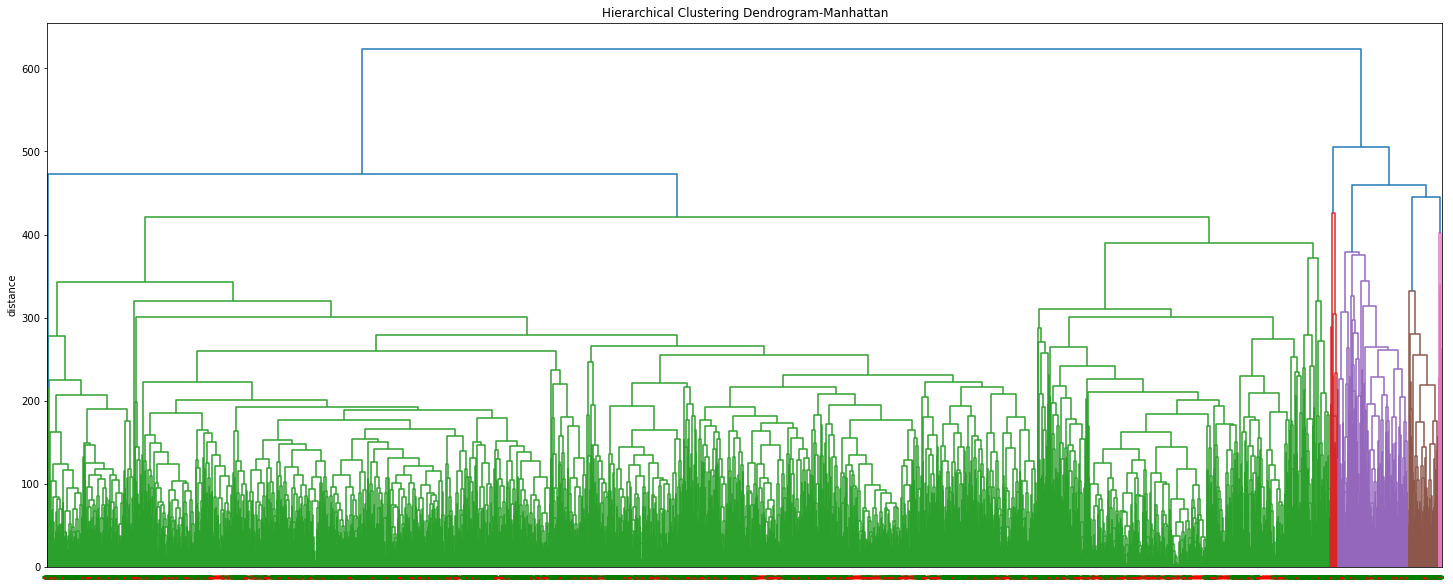

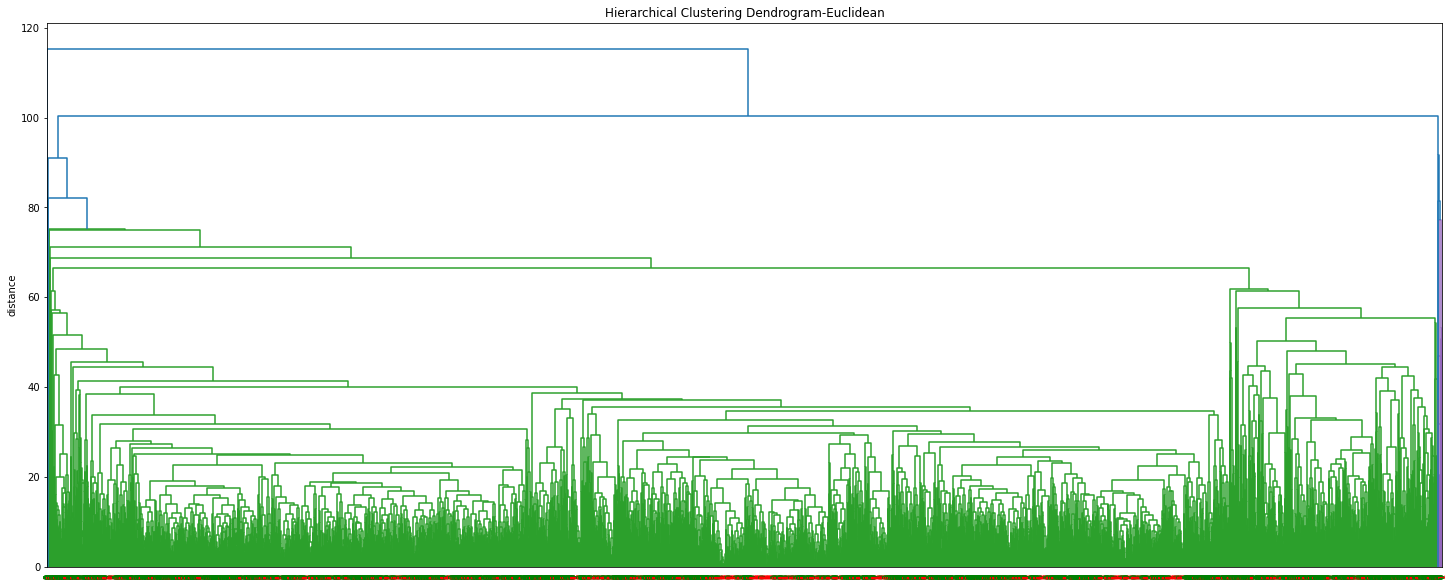

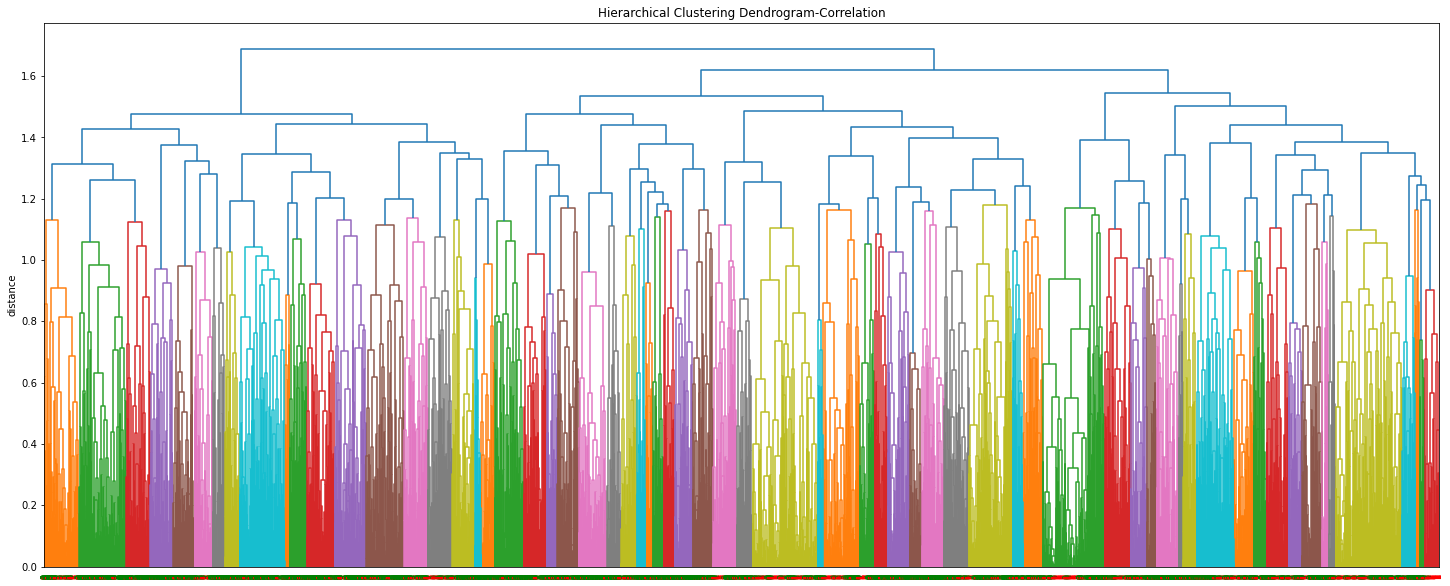

In [143]:
#Distância Manhattan
Z = linkage(data_scale, method='complete', metric='cityblock')

# calculate full dendrogram
plt.figure(figsize=(25, 10))
dendrogram(
    Z,
    labels=list(df_ames.iloc[:,2]),
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)

plt.title('Hierarchical Clustering Dendrogram-Manhattan')
plt.ylabel('distance')
# Plota o dendrograma colorindo as folhas de acordo com a classe
label_colors = {"1": 'r', "0": 'g'}
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

plt.show()

#Distância Euclidean
Z = linkage(data_scale, method='complete', metric='euclidean')

#calculate full dendrogram
plt.figure(figsize=(25, 10))
dendrogram(
    Z,
    labels=list(df_ames.iloc[:,2]),
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)

plt.title('Hierarchical Clustering Dendrogram-Euclidean')
plt.ylabel('distance')
# Plota o dendrograma colorindo as folhas de acordo com a classe
label_colors = {"1": 'r', "0": 'g'}
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

plt.show()

#correlation
Z = linkage(data_scale, method='complete', metric='correlation')

#calculate full dendrogram
df_global['Y'] = df_global['Y'].astype(str)
plt.figure(figsize=(25, 10))
dendrogram(
    Z,
    labels=list(df_ames.iloc[:,2]),
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)

plt.title('Hierarchical Clustering Dendrogram-Correlation')
plt.ylabel('distance')
# Plota o dendrograma colorindo as folhas de acordo com a classe
label_colors = {"1": 'r', "0": 'g'}
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])

plt.show()





Como o método de ligação (linkage) utilizado na construção do dendrograma pode influenciar na formação dos clusters decidimos explorar 2 tipos de métodos:

O método single une os dois clusters mais próximos, ou seja, as duas observações com menor distância entre si. Isso pode levar a formação de clusters com formas muito irregulares.

Por outro lado, o método complete  une os dois clusters mais distantes, ou seja, as duas observações com maior distância entre si. Isso tende a formar clusters mais compactos e esféricos.

Pela simples análise dos clusters obtidos,segundo o método single não se consegue retirar muita informação devido,  principalmente, à alta dimensionalidade dos  dados. Em altas dimensões, a distância Euclidiana e a distância Manhattan tendem a se tornar cada vez mais semelhantes, o que pode dificultar a formação de clusters significativos. Dessa forma tentamos melhorar o output com a exploração da distancia de correlação e verificamos ligeiras diferenças , todavia não é possivel observar a presenca de diversos clusters é como se todos os dados fossem praticamente agrupados num só cluster.

Os clusters obtidos com o método complete  podem criar clusters mais dispersos, porque leva em conta a distância máxima entre pontos de clusters diferentes daí neste método se estar a observar graficamente um maior aparecimento de clusters.

Em suma , método "complete" tende a formar clusters mais compactos e bem definidos, o que pode resultar em uma maior diversidade de cores no dendrograma, indicando uma maior variação nos tamanhos e formas dos clusters formados. Já o método "single" tende a formar clusters mais dispersos e menos definidos, o que pode levar a um dendrograma com menos cores, indicando que os clusters formados são mais uniformes e menos variáveis. No entanto, é importante lembrar que o número de clusters e a interpretação dos dendrogramas dependem de vários fatores, como a escolha da métrica de distância, o método de ligação e a configuração dos parâmetros do algoritmo de clustering.

Outra estratégia de clustering  permite visualizar a estrutura de agrupamento dos dados, mostrando como os diferentes elementos são agrupados em diferentes níveis de similaridade. Cada ramo no dendograma representa um cluster, e a altura do ponto de união dos ramos indica o nível de dissimilaridade entre os clusters agrupados. A interpretação do dendograma pode ajudar a identificar o número ideal de clusters, bem como a detectar padrões ou subgrupos nos dados. Além disso, a análise do dendograma também pode ajudar a entender as relações entre diferentes grupos e identificar quais são os elementos mais similares ou dissimilares no conjunto de dados.

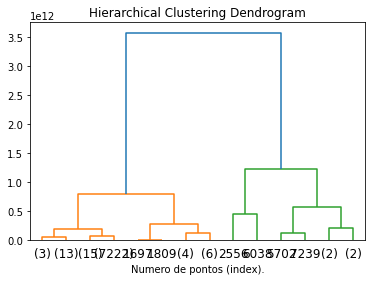

In [144]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(df_features)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Numero de pontos (index).")
plt.show()

A principal diferença entre os dendogramas gerados é a escala do eixo y. Quando usamos o método de clustering hierárquico com as métricas de distância euclidiana ou Manhattan, a distância entre os clusters é representada diretamente no eixo y, o que permite comparar visualmente a distância entre os clusters e determinar o número adequado de clusters a serem formados. No entanto, quando usamos o método aglomerativo com distance_threshold=0, o eixo y representa a dissimilaridade entre os clusters, em vez da distância, o que dificulta a determinação do número adequado de clusters. Portanto, é preciso definir um valor de corte na dissimilaridade para dividir o dendograma em clusters, o que pode ser mais subjetivo.

Pela interpetação do último clustering, é possivel observar a presença de 3 grupos distintos. Todavia, as distâncias de similaridade são muito altas o que significa que os objetos estão muito distantes uns dos outros em termos das suas características ou propriedades. Isso pode indicar que os objetos são muito diferentes entre si e podem ser agrupados em clusters diferentes. A dissimilaridade elevada pode indicar que há poucos clusters bem definidos, com grande variação entre eles. Isso pode levar a uma separação mais clara de poucos clusters, em vez de muitos clusters indistintos. No entanto, a interpretação exata das distâncias de similaridade depende do contexto do problema e dos dados sendo analisados.

### K-means

O algoritmo K-means começa com a seleção de K centroides iniciais, onde cada centroide representa o centro do cluster. Em seguida, o algoritmo atribui cada observação ao centroide mais próximo e calcula a média de todas as observações atribuídas a cada centroide para atualizar a posição do centroide. Esse processo é repetido até que os centroides não se movam mais ou até que um número máximo de iterações seja atingido. O objetivo do K-means é minimizar a soma das distâncias ao quadrado entre cada observação e o centroide do cluster ao qual ela foi atribuída.

Geralmente, o "método do cotovelo" sugere escolher o valor de k no ponto em que a melhoria no WSS (soma dos quadrados dentro dos clusters) começa a diminuir drasticamente, formando um "cotovelo" no gráfico. Portanto, o objetivo é encontrar o menor valor de k que ainda fornece uma redução significativa na variação dentro dos clusters.

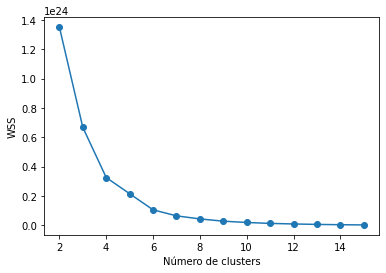

In [145]:
wss = []
for k in range(2, 16):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_features)
    wss.append(kmeans.inertia_)

plt.plot(range(2, 16), wss, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('WSS')
plt.show()

Pela interpretação do gráfico chegamos à conlcusão que o k mais apropriado será k=2, pois é aí onde há uma diminuição do valor de WSS mais acentuada.

In [150]:
k=2
kmeans_meta = KMeans(n_clusters=k, max_iter=1000)
kmeans_meta.fit(data_scale)
labels = kmeans_meta.labels_
centroids = kmeans_meta.cluster_centers_

pd.crosstab(labels,df_global["Y"], rownames=['clusters'] )

Y,0,1
clusters,,
0,2010,2341
1,1289,1633


O output obtido é uma tabela de contingência que mostra a distribuição dos pontos do conjunto de dados em relação aos clusters criados pelo algoritmo K-means. As linhas correspondem aos clusters e as colunas correspondem aos valores da variável Y. Cada célula mostra a contagem de pontos que pertencem a um determinado cluster e também têm um determinado valor de Y.
Com base na tabela, podemos ver que os valores de 2010 e 2341 foram atribuídos ao cluster 0, enquanto os valores de 1289 e 1633 foram atribuídos ao cluster 1. Isso sugere que há uma separação relativamente clara entre os dois clusters, mas também há alguma sobreposição nos valores das duas classes.

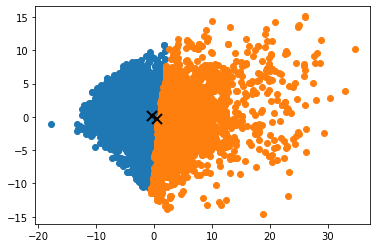

In [151]:
for i in range(k):
    # select only data observations with cluster label == i
    ds = X_r[np.where(labels==i)]
    # plot the data observations (only 2 first colums)
    plt.plot(ds[:,0],ds[:,1],'o')
    # plot the centroids
    lines = plt.plot(centroids[i,0],centroids[i,1],'kx')
    # make the centroid x's bigger
    plt.setp(lines,ms=10.0)    # x size 
    plt.setp(lines,mew=2.0)    #grossura da linha
    
# plot the centroids
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, linewidths=3, color='r')

plt.show()


Como no "método do cotovelo" também verificamos um declinio acentuado do parametro wss quando k=3, decidimos testar esse valor para verificar se por ventura a separação e respetiva sobreposição seria mais adequado.

In [164]:
k=3
kmeans_meta = KMeans(n_clusters=k, max_iter=1000)
kmeans_meta.fit(data_scale)
labels = kmeans_meta.labels_
centroids = kmeans_meta.cluster_centers_

pd.crosstab(labels,df_global["Y"], rownames=['clusters'] )

Y,0,1
clusters,,
0,428,596
1,1255,1441
2,1616,1937


Podemos verificar que as conclusões a serem retiradas são identicas ao que já foi referido anteriormente, onde temos uma boa separação mas com elevada sobreposição.

c:\Users\guilh\anaconda3\lib\site-packages\matplotlib\collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


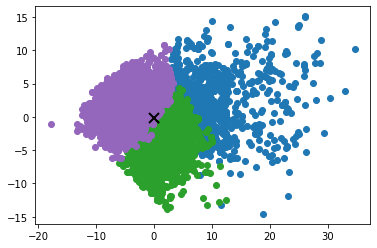

In [165]:
for i in range(k):
    # select only data observations with cluster label == i
    ds = X_r[np.where(labels==i)]
    # plot the data observations (only 2 first colums)
    plt.plot(ds[:,0],ds[:,1],'o')
    # plot the centroids
    lines = plt.plot(centroids[i,0],centroids[i,1],centroids[i,2],'kx')
    # make the centroid x's bigger
    plt.setp(lines,ms=10.0)    # x size 
    plt.setp(lines,mew=2.0)    #grossura da linha
    
# plot the centroids
plt.scatter(centroids[:, 0], centroids[:, 1],centroids[:, 2], marker='x', color='r')

plt.show()


A análise gráfica com k=2 e k=3, mostra visualmente o que se verificava nas tabelas de contigência, ou seja a clara formação de k clusters bem separados (principalmente com k=2),mas onde a sobreposição é abundadnte. Portanto não acontece o que provavelmente seria o cenário perfeito de ter 2 clusters completamente separados cada um com respetivo centroide associado e cada um a representar apenas Y=0 ou Y=1.

# Conclusão geral

Em suma, a análise realizada até então retrata a eventual dificuldade na previsão de uma determinada propriedade de um fármaco, neste caso em concreto a sua capacidade mutagénica. Isto é devido, essencialmente, ao facto de que apesar de existirem features (colunas) que têm uma maior preponderância, é a interação entre as diversas propriedades(colunas) que atribui ou não capacidade mutagénica. Como trabalho seguinte iremos explorar a uma aboradgem preditiva esperando conseguir através de um conjunto de dados prever a capacidade mutagénica (Y=0 ou Y=1) de uma determinada droga.

## Referências:

[1] Xu, Congying, et al. “In silico prediction of chemical Ames mutagenicity.” Journal of chemical information and modeling 52.11 (2012): 2840-2847.

[2] Smith, M. T. Advances in Understanding Benzene Health Effects and Susceptibility. Annu. Rev. Public Health, DOI: 10.1146/annurev.publhealth.012809.103646.


[3] Danishuddin, A. U. Khan. Descriptors and their selection methods in QSAR analysis: paradigm for drug design. Drug Discov. Today 2016, DOI: 10.1016/j.drudis.2016.06.013.


[4] Leo, A.; Hansch, C.; Elkins, D. Partition Coefficients and Their Uses. Chem. Rev. 1971, 71 (6), 525-616. DOI: 10.1021/cr60274a001.


[5] Hall, L. H.; Mohney, B.; Kier, L. B. The electrotopological state: An atom‐index for QSAR. Quant. Struct.-Act. Relat. 1991, 10 (2), 143-148. DOI: 10.1002/qsar.19910100108.


[6] Zámocký, M.; Koller, F. Hydrophobic and polar interactions of FDA-approved small molecule protein kinase inhibitors with their target enzymes. Pharmacol. Res. 2021, DOI: 10.1016/j.phrs.2021.105660.


[7] Sugimura, T.; Nagao, M.; Yahagi, T. Relationships between Electronegativity and Genotoxicity. Mutat. Res. Rev. Mutat. Res. 2000, 347 (1), 165-173. DOI: 10.1016/0027-5107(95)00011-7.



[8] Bickerton, G. R.; Paolini, G. V.; Besnard, J.; Muresan, S.; Hopkins, A. L. Quantifying the Chemical Beauty of Drugs. Nat. Chem. 2012, 4 (2), 90-98. DOI: 10.1038/nchem.1243.


[9] Laguionie-Marchais, C.; Allcock, A. L.; Baker, B. J.; Conneely, E.-A.; Dietrick, S. G.; Kearns, F. et al. Not Drug-like, but Like Drugs: Cnidaria Natural Products. Mar. Drugs 2022, 20, 42. DOI: 10.3390/md20010042.


[10] Hsu, K. H., Su, B. H., Tu, Y. S., Lin, O. A., & Tseng, Y. J. (2016). Mutagenicity in a Molecule: Identification of Core Structural Features of Mutagenicity Using a Scaffold Analysis. PLoS One, 11(2), e0148900. DOI:10.1371/journal.pone.0148900.